<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional Handwriting GAN

## Imports
Dependencies needed to run the code, including mounting GoogleDrive and copying files.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import time
from PIL import Image, ImageOps
import gc
import pdb
import pandas as pd
import cv2
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "drive/My Drive/datasets/iam.zip" "/content"

In [4]:
!unzip -q iam.zip
!rm iam.zip

warning [iam.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [iam.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #95170).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


## Helper Functions

In [0]:
# helper function to initialize the weights using a normal distribution. 
# this was done in the original work (instead of xavier) and has been shown
# to help GAN performance
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [0]:
def tensor_to_image(t):
  return transforms.ToPILImage()(t).convert("L")

In [0]:
def show_imgs(x, new_fig=True):
    grid = utils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

In [0]:
def word_lengths_tensor(words):
  lengths = []

  if type(words) == str:
    length = len(word)
    if length > 16:
      length = 16
    lengths.append(length)
    return torch.tensor(lengths)
  else:
    for word in words:
      length = len(word)
      if length > 16:
        length = 16
      lengths.append(length)
    return torch.tensor(lengths)

In [0]:
def parameter_count(model):
  return sum(p.numel() for p in model.parameters())

## Dataset

In [0]:
class IamDataset(Dataset):
  def __init__(self, desired_size=(128, 512)):
    if not os.path.exists('/content/labels.csv'):
      raise Exception('Iam dataset does not exist in /content/labels.csv')

    self.desired_size = desired_size
    self.path = '/content/images/'
    self.df = pd.read_csv('/content/labels.csv', sep='\t', header=None, names=['word', 'seg', 'transcription'])
    self.df = self.df.drop(['seg'], axis=1)
    self.df = self.df.drop(self.df[self.df['transcription'] == '.'].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == '!'].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == ','].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == ';'].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == ')'].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == '('].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == ':'].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == '"'].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == '\''].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == '?'].index)
    self.df = self.df.reset_index()
    
  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path + '.png')
    img = self.resize(img)
    x = transforms.functional.to_tensor(img)

    # Look into automatically resizing or adding padding to images
    # With a GAN, we will likely need all the input images to be the same size

    return x

  def resize(self, img):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = self.desired_size[0] / self.desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = self.desired_size[0]
      new_width = int(self.desired_size[0] // img_ratio)
    else:
      new_height = int(self.desired_size[1] * img_ratio)
      new_width = self.desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = self.desired_size[0] - new_height
    border_right = self.desired_size[1] - new_width

    border_img = cv2.copyMakeBorder(
        img,
        top=border_top,
        bottom=0,
        left=0,
        right=border_right,
        borderType=cv2.BORDER_CONSTANT,
        value=[255]
    )

    return border_img

  def __getitem__(self, index):
    img = self.tensor_image('images/' + self.df['word'][index])

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)

In [11]:
dataset = IamDataset()
len(dataset)

85434

Label:  British


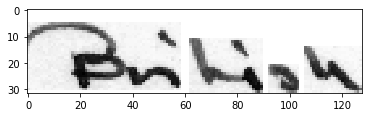

In [12]:
dataset = IamDataset((32, 128))
imgnum = 9002
print('Label: ', dataset[imgnum][1])
imshow(dataset[imgnum][0].numpy().squeeze(0), cmap='gray')

## Helper Modules

In [0]:
class HingeLoss(nn.Module):
    def __init__(self, margin=1.0, size_average=True, sign=1.0):
        super(HingeLoss, self).__init__()
        self.sign = sign
        self.margin = margin
        self.size_average = size_average
 
    def forward(self, input, target):
        input = input.view(-1)

        assert input.dim() == target.dim()
        for i in range(input.dim()): 
            assert input.size(i) == target.size(i)

        output = self.margin - torch.mul(target, input)
     
        if 'cuda' in input.data.type():
            mask = torch.cuda.FloatTensor(input.size()).zero_()
        else:
            mask = torch.FloatTensor(input.size()).zero_()
        mask = Variable(mask)
        mask[torch.gt(output, 0.0)] = 1.0

        output = torch.mul(output, mask)

        # size average
        if self.size_average:
            output = torch.mul(output, 1.0 / input.nelement())

        # sum
        output = output.sum()

        # apply sign
        output = torch.mul(output, self.sign)
        return output

In [14]:
fake = torch.full((1, 1), .1)
real = torch.full((1,), .9)
print(real.shape)

preds_real = torch.tensor([.5])
preds_fake = torch.tensor([[.232], [.523]])

print(preds_real.shape)

loss = HingeLoss()

loss(preds_real, real)

torch.Size([1])
torch.Size([1])


tensor(0.5500)

In [15]:
loss = nn.CrossEntropyLoss()

input_t = torch.tensor([[1., 0.]])
target_t = torch.tensor([1])

loss(input_t, target_t)

tensor(1.3133)

In [16]:
loss = nn.BCELoss()

input_t = torch.tensor([0.])
target_t = torch.tensor([1.])

loss(input_t, target_t)

tensor(27.6310)

In [17]:
torch.full((1, 1), .1).view(-1)

tensor([0.1000])

In [18]:
loss = HingeLoss()

input_t = torch.tensor([[.8]])
target_t = torch.tensor([1])

loss(input_t, target_t)

tensor(0.2000)

In [0]:
class ConditionalBatchNorm2d(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.num_features = num_features
    self.bn = nn.BatchNorm2d(num_features, affine=False)

  def forward(self, x, gamma, beta):
    out = self.bn(x)
    out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
    return out

In [0]:
class SumPooling(nn.Module):
  def __init__(self, dim=2):
    super(SumPooling, self).__init__()

    self.dim = dim

  def forward(self, x):
    return torch.sum(x.view(x.size(0), x.size(1), -1), dim=self.dim)

In [0]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super(Self_Attn, self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out #,attention

In [0]:
class ResBlockUp(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResBlockUp, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels

    self.cbn1 = ConditionalBatchNorm2d(in_channels)
    self.relu = nn.ReLU()
    self.upsample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)
    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
    self.cbn2 = ConditionalBatchNorm2d(out_channels)
    self.relu2 = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)

    self.beta_conv = nn.Conv2d(in_channels, out_channels, 1, 1) # 1x1 kernels to reshape beta/gamma
    self.gamma_conv = nn.Conv2d(in_channels, out_channels, 1, 1)

    self.upsample_i = nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1)
    self.conv_i = nn.Conv2d(in_channels, out_channels, 1, 1)

  # Input should be (batch, 256, 1, 4) beta -> embedding, gamma -> noise
  def forward(self, x, beta, gamma):
    beta_out = beta
    gamma_out = gamma

    # Reshape identity so we can sum at the end
    identity = x
    identity = self.upsample_i(identity)
    if self.in_channels != self.out_channels:
      identity = self.conv_i(identity)

      # Reshape beta and gamma
      beta_out = self.beta_conv(beta.view(-1, self.in_channels, 1, 1))
      gamma_out = self.gamma_conv(gamma.view(-1, self.in_channels, 1, 1))

    out = self.cbn1(x, beta, gamma)
    out = self.relu(out)
    out = self.upsample(out)
    out = self.conv1(out)
    out = self.cbn2(out, beta_out, gamma_out)
    out = self.relu2(out)
    out = self.conv2(out)

    out += identity

    return out, beta_out, gamma_out

In [0]:
class ResBlockDown(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResBlockDown, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels

    self.bn1 = nn.BatchNorm2d(in_channels)
    self.lrelu = nn.LeakyReLU()
    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.lrelu2 = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
    self.avgpool = nn.AvgPool2d(2)

    self.conv_i = nn.Conv2d(in_channels, out_channels, 1, 1)
    self.avgpool_i = nn.AvgPool2d(2)

  # Input should be (batch, 256, 1, 4) beta -> embedding, gamma -> noise
  def forward(self, x):
    # Reshape identity so we can sum at the end
    identity = x
    if self.in_channels != self.out_channels:
      identity = self.conv_i(identity)
    identity = self.avgpool_i(identity)

    out = self.bn1(x)
    out = self.lrelu(out)
    out = self.conv1(out)
    out = self.bn2(out)
    out = self.lrelu2(out)
    out = self.conv2(out)
    out = self.avgpool(out)

    out += identity

    return out

In [0]:
class ResBlockNorm(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResBlockNorm, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.lrelu1 = nn.LeakyReLU()
    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.lrelu2 = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)

    self.conv_i = nn.Conv2d(in_channels, out_channels, 1, 1)

  def forward(self, x):
    identity = x
    if self.in_channels != self.out_channels:
      identity = self.conv_i(identity)

    out = self.bn1(x)
    out = self.lrelu1(out)
    out = self.conv1(out)
    out = self.bn2(out)
    out = self.lrelu2(out)
    out = self.conv2(out)

    out += identity

    return out

## GAN Modules

In [0]:
class Encoder(nn.Module):
  def __init__(self, dim=128, layers=4):
    super(Encoder, self).__init__()

    self.layers = layers
    self.dim = dim

    # input_size, hidden_size, num_layers, bidirectional=True
    self.gru = nn.GRU(1, dim, layers, bidirectional=True, batch_first=True)
    self.fc = nn.Linear(256, 16) # used to match up shapes when given to generator

    self.hidden_init_state = torch.randn((8, 1, dim), requires_grad=True)
    self.embedding = nn.Embedding(128, 1)

  def getRepresentation(words):
    charlists = []
    zeros = np.zeros(20)

    if type(words) == str:
      charlist = [ord(c) for c in words]
      charlist = np.concatenate((charlist, zeros))
      charlists.append(charlist[:16])

      return torch.tensor(charlists).long().cuda()

    for word in words:
      charlist = [ord(c) for c in word]
      charlist = np.concatenate((charlist, zeros))
      charlists.append(charlist[:16])

    return torch.tensor(charlists).long().unsqueeze(2).cuda()

  # input => (tuple of strings)
  def getEmbedding(words, embedding):
    rep = Encoder.getRepresentation(words)
    
    return embedding(rep)

  def init_hidden(self, batch):
    return torch.zeros(self.layers * 2, batch, self.dim).cuda()

  def weight_init(self, mean, std):
      for m in self._modules:
          normal_init(self._modules[m], mean, std)
    
  # input -> embedding
  def forward(self, embedding):
    hidden_state = self.init_hidden(embedding.shape[0])

    out, _ = self.gru(embedding.float(), hidden_state)
    out = self.fc(out)
    out = out.view(-1, 1, 1, 256)

    return out

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.fc = nn.Linear(128, 1024)

    self.rb1 = ResBlockUp(256, 256)
    self.rb2 = ResBlockUp(256, 128)
    # self.rb3 = ResBlockUp(128, 128)
    self.rb4 = ResBlockUp(128, 64)

    self.attn = Self_Attn(64)

    self.rb5 = ResBlockUp(64, 32)
    self.rb6 = ResBlockUp(32, 16)
    # self.rb7 = ResBlockUp(16, 16)

    self.bn = nn.BatchNorm2d(16)
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(16, 1, 3, 1, 1)
    self.tanh = nn.Tanh()

  def weight_init(self, mean, std):
    for m in self._modules:
        normal_init(self._modules[m], mean, std)


  # Input should be 128 dimensional z-vector
  # x -> z-latent vector, beta -> word embedding, gamma -> noise
  # x -> (batch, 128), beta -> (batch, 1, 1, 256), noise -> (batch, 1, 1, 256)
  def forward(self, x, beta, gamma):
    out = self.fc(x)
    out = out.view(-1, 256, 1, 4)
    out, beta_out, gamma_out = self.rb1(out, beta, gamma)
    out, beta_out, gamma_out = self.rb2(out, beta_out, gamma_out)
    # out, beta_out, gamma_out = self.rb3(out, beta_out, gamma_out)
    out, beta_out, gamma_out = self.rb4(out, beta_out, gamma_out)
    out = self.attn(out)
    out, beta_out, gamma_out = self.rb5(out, beta_out, gamma_out)
    out, beta_out, gamma_out = self.rb6(out, beta_out, gamma_out)
    # out, beta_out, gamma_out = self.rb7(out, beta_out, gamma_out)
    out = self.bn(out)
    out = self.relu(out)
    out = self.conv(out)
    out = self.tanh(out)

    return out

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.rb1 = ResBlockDown(1, 16)
    # self.rb2 = ResBlockDown(16, 16)
    self.rb3 = ResBlockDown(16, 32)

    self.attn = Self_Attn(32)

    self.rb4 = ResBlockDown(32, 64)
    self.rb5 = ResBlockDown(64, 128)
    # self.rb6 = ResBlockDown(128, 128)
    self.rb7 = ResBlockDown(128, 256)
    self.rb8 = ResBlockNorm(256, 256)

    self.sp = SumPooling()
    self.fc = nn.Linear(256, 1)
    self.sigmoid = nn.Sigmoid()

  def weight_init(self, mean, std):
    for m in self._modules:
        normal_init(self._modules[m], mean, std)

  def forward(self, x):
    out = self.rb1(x)
    # out = self.rb2(out)
    out = self.rb3(out)
    out = self.attn(out)
    out = self.rb4(out)
    out = self.rb5(out)
    # out = self.rb6(out)
    out = self.rb7(out)
    out = self.rb8(out)
    out = self.sp(out)
    out = self.fc(out)
    out = self.sigmoid(out)

    return out

In [0]:
class Recognizer(nn.Module):
  def __init__(self):
    super(Recognizer, self).__init__()

    self.hidden_size = 256
    self.num_layers = 1
    self.max_length = 20

    # Encoder
    self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
    self.tanh1 = nn.Tanh()
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1) # 4x2
    self.tanh2 = nn.Tanh()
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.tanh3 = nn.Tanh()
    self.conv4 = nn.Conv2d(32, 64, 3, 1, 1) # 4x2
    self.tanh4 = nn.Tanh()
    self.conv5 = nn.Conv2d(64, 128, 3, 1, 1)
    self.tanh5 = nn.Tanh()

    self.gate1 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate3 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())

    # Maxpool
    self.mp = nn.MaxPool2d((32, 1))
    # reshape out.view(-1, 512, 1)

    # Decoder
    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, 16)
    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    return torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)

  def weight_init(self, mean, std):
    for m in self._modules:
        normal_init(self._modules[m], mean, std)

  # Input -> (Batch, 1, 128, 256)
  def forward(self, x):
    # Encoder
    out = self.conv1(x)
    out = self.tanh1(out)
    out = self.conv2(out)
    out = self.tanh2(out)

    gate1 = self.gate1(out)
    out = out * gate1

    out = self.conv3(out)
    out = self.tanh3(out)

    gate2 = self.gate2(out)
    out = out * gate2

    out = self.conv4(out)
    out = self.tanh4(out)

    gate3 = self.gate3(out)
    out = out * gate3

    out = self.conv5(out)
    out = self.tanh5(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = out.view(-1, 128, 128)

    out, _ = self.gru1(out)
    out = self.fc1(out)
    out, _ = self.gru2(out)
    out = self.fc2(out)
    out = self.softmax(out)

    # Change shape so that we can pass directly to CTC-Loss
    out = out.permute(2, 0, 1)

    return out

## Training

In [226]:
a = torch.tensor([.034, .342, .84, .99])
b = torch.tensor([0., 1., 1., 0.])
losses = nn.BCELoss(reduction='none')(a,b)

for loss in losses:
  print(loss.item())

0.0345914252102375
1.0729445219039917
0.17435342073440552
4.605171203613281


In [35]:
disc_loss = [0.3324, 0.6543, 0.6411, 0.5889, 0.6613, 0.5492, 0.7341, 0.6367, 0.8794,
             0.9521, 0.6082, 0.4800, 0.7252, 0.5913, 0.5169, 0.4685, 0.7944, 1.0635,
             0.6446, 0.4846, 0.5441, 0.5588, 0.5834, 0.6244, 0.3998, 0.8697, 0.4852,
             0.6807, 0.7354, 0.3697, 0.8482, 0.4637, 0.6325, 0.3297, 0.6349, 0.4734,
             0.5647, 0.3326, 0.6142, 0.3314, 0.5086, 0.3524, 0.7934, 0.5096, 0.7519,
             0.6818, 0.5352, 0.4184, 1.0261, 0.8889, 0.5767, 0.9806, 0.6609, 0.5734,
             0.6075, 0.5000, 0.6322, 0.5492, 0.6072, 0.7878, 1.0238, 0.5396, 0.6787,
             0.4873, 0.6947, 0.5973, 0.6569, 0.8527, 0.5478, 0.5645, 0.3257, 1.2879,
             0.6948, 0.6830, 0.7252, 0.8716, 1.1701, 0.4130, 0.5213, 0.9458, 0.6211,
             0.7462, 0.3355, 0.6441, 0.3656, 0.9187, 0.4919, 0.3285, 0.7561, 0.3466,
             0.7201, 0.5806, 0.3599, 0.6646, 0.7002, 0.6095, 0.4628, 0.3326, 0.9552,
             0.5414]

rec_loss = [50000, 5000, 69.5858, 67.4064, 65.8125, 69.5858, 64.8450, 64.2402,
            65.8728, 69.5857, 67.4062, 64.8448, 69.5858, 64.2403, 64.8449, 65.2100,
            67.4061, 67.4061, 64.2403, 67.4061, 67.4061, 69.5857, 67.4062, 67.4061,
            64.0076, 65.8728, 64.0077, 69.5858, 69.5857, 65.2786, 64.1143, 65.8728,
            65.8726, 64.0076, 67.7843, 67.4062, 67.4063, 65.0270, 67.7844, 69.5858,
            65.8729, 67.4061, 64.8447, 67.4061, 67.4062, 64.0077, 69.5857, 64.0076,
            65.8730, 64.2403, 65.8729, 64.0076, 69.5858, 64.0076, 67.7844, 64.1142,
            71.5553, 72.6947, 64.9439, 65.8730, 64.2402, 64.2402, 65.8728, 67.4062,
            72.6947, 67.4060, 65.8728, 65.8728, 64.1143, 69.5858, 64.8449, 69.5858,
            69.5858, 64.2402, 65.8728, 64.8450, 69.5858, 72.6947, 72.6947, 67.4064,
            64.0076, 69.4257, 65.8729, 64.2402, 67.4061, 67.4062, 65.2099, 69.5857,
            64.0076, 64.1143, 65.8728, 65.8728, 64.8448, 64.8449, 69.5858, 69.5858,
            67.4062, 64.9435, 67.7009, 69.5858]

disc_t = torch.tensor(disc_loss)
rec_t = torch.tensor(rec_loss)

gradient_balancing(disc_t, rec_t)

[2.576640135348624, 0.8008972331194004, 0.606338388221696, 0.6062523871152701, 0.6061894901995525, 0.606338388221696, 0.6061513117753247, 0.606127445593703, 0.6061918698029425, 0.6063383843078746, 0.6062523789865641, 0.6061513039476819, 0.606338388221696, 0.6061274498085876, 0.6061513078615033, 0.6061657149390117, 0.6062523750727428, 0.6062523750727428, 0.6061274498085876, 0.6062523750727428, 0.6062523750727428, 0.6063383843078746, 0.6062523789865641, 0.6062523750727428, 0.6061182670804752, 0.6061918698029425, 0.6061182709942966, 0.606338388221696, 0.6063383843078746, 0.6061684220991437, 0.6061224777501378, 0.6061918698029425, 0.6061918616742367, 0.6061182670804752, 0.6062672993767978, 0.6062523789865641, 0.6062523832014487, 0.6061584936375298, 0.6062673032906192, 0.606338388221696, 0.6061918737167639, 0.6062523750727428, 0.6061513000338605, 0.6062523750727428, 0.6062523789865641, 0.6061182709942966, 0.6063383843078746, 0.6061182670804752, 0.6061918776305852, 0.6061274498085876, 0.6061

(tensor(0.6279), tensor(0.6279))

In [0]:
def gradient_balancing(disc_losses, rec_losses):
  disc_mean = torch.mean(disc_losses)
  disc_std = torch.std(disc_losses)

  rec_mean = torch.mean(rec_losses)
  rec_std = torch.std(rec_losses)

  transformed_losses = []

  for loss in rec_losses:
    transformed_loss = ((disc_std.item() / rec_std.item()) * (loss.item() - rec_mean.item())) + disc_mean.item()
    transformed_losses.append(transformed_loss)

  print(transformed_losses)

  print(disc_losses)

  return disc_mean, torch.mean(torch.tensor(transformed_losses))

In [0]:
# In future, potentially apply gradient balancing

def train():
  try:
    EPOCHS = 200
    BATCH_SIZE = 100
    RATIO = 1 # How many times will we train the generator for each time we train the discriminator
    IMG_ITERATIONS = 100 # Show example generator image after how many iterations

    dataset = IamDataset(desired_size=(32, 128))
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    encoder = Encoder().cuda()
    encoder.weight_init(mean=0.0, std=0.02)
    generator = Generator().cuda()
    generator.weight_init(mean=0.0, std=0.02)
    discriminator = Discriminator().cuda()
    discriminator.weight_init(mean=0.0, std=0.02)
    recognizer = Recognizer().cuda()
    recognizer.weight_init(mean=0.0, std=0.02)

    embedding_module = nn.Embedding(128, 1).cuda()

    gen_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0, .999))
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0, .999))
    rec_optimizer = optim.Adam(recognizer.parameters(), lr=2e-4, betas=(0, .999))

    gen_objective = nn.BCELoss()
    disc_objective = nn.BCELoss()
    rec_objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)

    g_losses = []
    d_losses = []
    r_losses = []

    for epoch in range(EPOCHS):
      loop = tqdm(total=len(data_loader), position=0, leave=False)

      for batch_num, (real_imgs, words) in enumerate(data_loader):
        batch_size = real_imgs.shape[0]

        real_imgs, labels = real_imgs.cuda(), Encoder.getRepresentation(words).cuda()

        # Create labels for real/fake images
        fake_labels = torch.full((real_imgs.shape[0], 1), .1).squeeze().cuda() # Label Smoothing .1 -> fake_labels, .9 -> real_labels
        real_labels = torch.full((real_imgs.shape[0], 1), .9).squeeze().cuda()

        # Generate Fake Images

        # Set up variables to send to generator
        z = torch.randn(batch_size, 128).cuda()
        embedding = encoder(labels).cuda()
        noise = torch.randn(batch_size, 1, 1, 256).cuda()

        # Set up parameters needed for CTC-Loss in Generator/Recognizer
        real_word_labels = labels.squeeze().long()
        input_lengths = torch.full((batch_size,), 16, dtype=torch.long) # (BATCH_SIZE) -> Sequence_Length
        target_lengths = word_lengths_tensor(words) # (BATCH_SIZE) -> Word lengths

        fake_imgs = generator(z, embedding, noise)

        # Train Generator
        gen_optimizer.zero_grad()

        fake_preds = discriminator(fake_imgs).squeeze()

        gen_disc_loss = gen_objective(fake_preds, real_labels)

        # Only train with recognizer loss every few epochs according to the ratio
        if batch_num % RATIO == 0:
          fake_preds_rec = recognizer(fake_imgs)
          gen_rec_loss = rec_objective(fake_preds_rec, real_word_labels, input_lengths, target_lengths)

          gen_rec_loss = torch.mean(gen_rec_loss)
          gen_loss = 0.5 * (gen_rec_loss + gen_disc_loss)
        else:
          gen_loss = gen_disc_loss

        gen_loss.backward()
        gen_optimizer.step()

        g_losses.append(gen_loss.item())

        # Train Discriminator / Train Recognizer
        if batch_num % RATIO == 0:
          # Discriminator
          disc_optimizer.zero_grad()

          fake_preds = discriminator(fake_imgs.detach()).squeeze()
          real_preds = discriminator(real_imgs).squeeze()

          fake_loss = disc_objective(fake_preds, fake_labels)
          real_loss = disc_objective(real_preds, real_labels)
          disc_loss = 0.5 * (fake_loss + real_loss)

          disc_loss.backward()
          disc_optimizer.step()

          d_losses.append(disc_loss.item())

          # Recognizer
          rec_optimizer.zero_grad()

          real_preds = recognizer(real_imgs)

          rec_loss = rec_objective(real_preds, real_word_labels, input_lengths, target_lengths)
          rec_loss = torch.mean(rec_loss)

          rec_loss.backward()
          rec_optimizer.step()

          r_losses.append(rec_loss.item())

        if batch_num % IMG_ITERATIONS == 0:
          print('\nLabels: ', words[:4])
          show_imgs(fake_imgs[:4])
          plt.pause(1)

        loop.set_description('Epoch: {}, Generator Loss: {:.4f}, Discriminator Loss: {:.4f}, Recognizer Loss: {:.4f}, AvgGenerator Loss: {:.4f}, AvgDiscriminator Loss: {:.4f}, AvgRecognizer Loss: {:.4f}'.format(
            epoch, gen_loss.item(), disc_loss.item(), rec_loss.item(), np.mean(g_losses), np.mean(d_losses), np.mean(r_losses)))
        loop.update(1)

      loop.close()
    
  except:
    __ITB__()
    gc.collect()
  finally:
    return generator, recognizer, discriminator, g_losses, d_losses, r_losses

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('psychologist', "didn't", 'so', 'advantages')


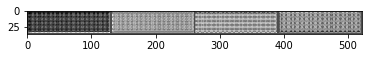

Epoch: 0, Generator Loss: 9.3018, Discriminator Loss: 0.3443, Recognizer Loss: 16.1518, AvgGenerator Loss: 15.3421, AvgDiscriminator Loss: 0.5929, AvgRecognizer Loss: 27.2102:  12%|█▏        | 100/855 [01:18<09:54,  1.27it/s]


Labels:  ('want', 'Hugh', 'that', 'about')


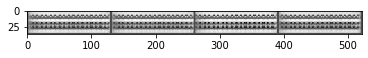

Epoch: 0, Generator Loss: 9.1951, Discriminator Loss: 0.3430, Recognizer Loss: 16.3428, AvgGenerator Loss: 12.5265, AvgDiscriminator Loss: 0.4794, AvgRecognizer Loss: 22.2351:  23%|██▎       | 200/855 [02:37<08:36,  1.27it/s]


Labels:  ('the', 'in', 'you', 'enjoying')


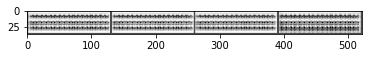

Epoch: 0, Generator Loss: 9.0598, Discriminator Loss: 0.3498, Recognizer Loss: 16.0187, AvgGenerator Loss: 11.4306, AvgDiscriminator Loss: 0.4360, AvgRecognizer Loss: 20.3485:  35%|███▌      | 300/855 [03:56<07:14,  1.28it/s]


Labels:  ('medical', 'seemed', "wife's", 'makes')


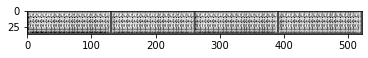

Epoch: 0, Generator Loss: 9.1615, Discriminator Loss: 0.3640, Recognizer Loss: 17.4380, AvgGenerator Loss: 10.8317, AvgDiscriminator Loss: 0.4110, AvgRecognizer Loss: 19.3318:  47%|████▋     | 400/855 [05:16<05:59,  1.27it/s]


Labels:  ('their', 'a', 'personal', 'and')


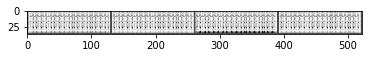

Epoch: 0, Generator Loss: 9.8856, Discriminator Loss: 0.3678, Recognizer Loss: 17.4770, AvgGenerator Loss: 10.4553, AvgDiscriminator Loss: 0.3961, AvgRecognizer Loss: 18.6773:  58%|█████▊    | 500/855 [06:36<04:38,  1.27it/s]


Labels:  ('eat', 'oppose', 'action', 'and')


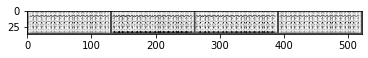

Epoch: 0, Generator Loss: 8.3641, Discriminator Loss: 0.3273, Recognizer Loss: 14.7909, AvgGenerator Loss: 10.2094, AvgDiscriminator Loss: 0.4125, AvgRecognizer Loss: 18.2249:  70%|███████   | 600/855 [07:55<03:18,  1.28it/s]


Labels:  ('quiet', 'tempted', 'likewise', 'that')


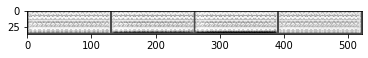

Epoch: 0, Generator Loss: 9.1760, Discriminator Loss: 0.3316, Recognizer Loss: 16.1281, AvgGenerator Loss: 10.0255, AvgDiscriminator Loss: 0.4014, AvgRecognizer Loss: 17.8923:  82%|████████▏ | 700/855 [09:15<02:01,  1.27it/s]


Labels:  ('after', 'of', 'But', 'students')


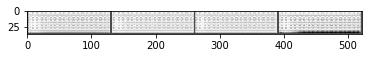

Epoch: 0, Generator Loss: 8.8792, Discriminator Loss: 0.3300, Recognizer Loss: 16.2855, AvgGenerator Loss: 9.8784, AvgDiscriminator Loss: 0.3932, AvgRecognizer Loss: 17.6223:  94%|█████████▎| 800/855 [10:34<00:43,  1.27it/s]


Labels:  ('of', 'today', 'negotiating', 'to')


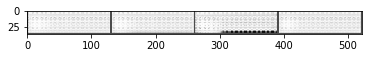

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('assumption', 'may', 'on', 'realise')


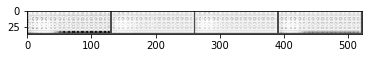

Epoch: 1, Generator Loss: 9.2794, Discriminator Loss: 0.3369, Recognizer Loss: 16.7968, AvgGenerator Loss: 9.6957, AvgDiscriminator Loss: 0.3833, AvgRecognizer Loss: 17.2879:  12%|█▏        | 100/855 [01:19<09:50,  1.28it/s]


Labels:  ('as', 'he', 'a', 'of')


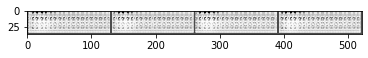

Epoch: 1, Generator Loss: 9.4722, Discriminator Loss: 0.3289, Recognizer Loss: 17.3815, AvgGenerator Loss: 9.5876, AvgDiscriminator Loss: 0.3783, AvgRecognizer Loss: 17.1085:  23%|██▎       | 200/855 [02:39<08:30,  1.28it/s]


Labels:  ('selected', 'of', 'night', 'is')


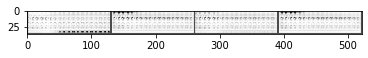

Epoch: 1, Generator Loss: 8.3597, Discriminator Loss: 0.3280, Recognizer Loss: 15.0440, AvgGenerator Loss: 9.4905, AvgDiscriminator Loss: 0.3743, AvgRecognizer Loss: 16.9605:  35%|███▌      | 300/855 [03:58<07:15,  1.27it/s]


Labels:  ('leadership', 'contrast', 'train', 'were')


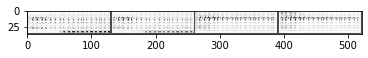

Epoch: 1, Generator Loss: 8.0590, Discriminator Loss: 0.3278, Recognizer Loss: 15.1239, AvgGenerator Loss: 9.4020, AvgDiscriminator Loss: 0.3709, AvgRecognizer Loss: 16.8255:  47%|████▋     | 400/855 [05:18<05:58,  1.27it/s]


Labels:  ('his', 'he', 'the', 'his')


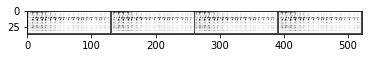

Epoch: 1, Generator Loss: 8.9851, Discriminator Loss: 0.3260, Recognizer Loss: 16.5484, AvgGenerator Loss: 9.3231, AvgDiscriminator Loss: 0.3678, AvgRecognizer Loss: 16.7038:  58%|█████▊    | 500/855 [06:37<04:38,  1.28it/s]


Labels:  ('habits', 'means', 'had', 'are')


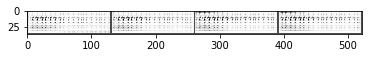

Epoch: 1, Generator Loss: 8.2315, Discriminator Loss: 0.3276, Recognizer Loss: 14.6449, AvgGenerator Loss: 9.2514, AvgDiscriminator Loss: 0.3651, AvgRecognizer Loss: 16.5921:  70%|███████   | 600/855 [07:57<03:19,  1.28it/s]


Labels:  ('Mr', 'strip', 'the', 'they')


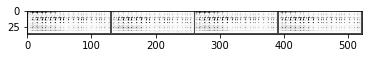

Epoch: 1, Generator Loss: 7.8719, Discriminator Loss: 0.3299, Recognizer Loss: 14.0480, AvgGenerator Loss: 9.1841, AvgDiscriminator Loss: 0.3628, AvgRecognizer Loss: 16.4818:  82%|████████▏ | 700/855 [09:17<02:01,  1.27it/s]


Labels:  ('against', 'sugya', 'and', 'in')


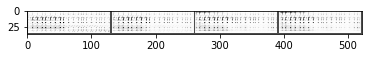

Epoch: 1, Generator Loss: 6.7770, Discriminator Loss: 0.6826, Recognizer Loss: 13.6495, AvgGenerator Loss: 9.1225, AvgDiscriminator Loss: 0.3716, AvgRecognizer Loss: 16.3876:  94%|█████████▎| 800/855 [10:36<00:43,  1.27it/s]


Labels:  ('THE', 'Replying', 'to', 'looking')


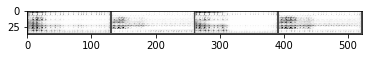

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('expert', 'heart', 'Immediately', 'for')


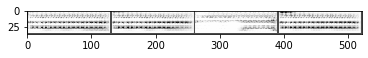

Epoch: 2, Generator Loss: 8.3009, Discriminator Loss: 0.3291, Recognizer Loss: 14.6791, AvgGenerator Loss: 9.0457, AvgDiscriminator Loss: 0.3710, AvgRecognizer Loss: 16.2580:  12%|█▏        | 100/855 [01:19<09:54,  1.27it/s]


Labels:  ('precisely', 'Quixotic', 'this', 'fruit')


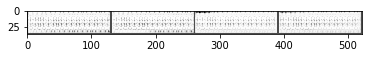

Epoch: 2, Generator Loss: 8.7412, Discriminator Loss: 0.3258, Recognizer Loss: 15.7972, AvgGenerator Loss: 9.0020, AvgDiscriminator Loss: 0.3688, AvgRecognizer Loss: 16.1773:  23%|██▎       | 200/855 [02:39<08:32,  1.28it/s]


Labels:  ('His', 'of', 'highest', 'war')


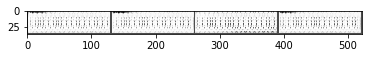

Epoch: 2, Generator Loss: 7.8574, Discriminator Loss: 0.3266, Recognizer Loss: 13.9402, AvgGenerator Loss: 8.9624, AvgDiscriminator Loss: 0.3666, AvgRecognizer Loss: 16.1039:  35%|███▌      | 300/855 [03:59<07:13,  1.28it/s]


Labels:  ('there', 'lot', 'is', 'rising')


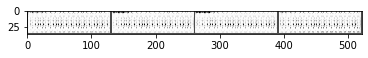

Epoch: 2, Generator Loss: 7.6370, Discriminator Loss: 0.3255, Recognizer Loss: 13.3226, AvgGenerator Loss: 8.9250, AvgDiscriminator Loss: 0.3647, AvgRecognizer Loss: 16.0323:  47%|████▋     | 400/855 [05:18<05:56,  1.27it/s]


Labels:  ('with', 'or', 'was', 'letting')


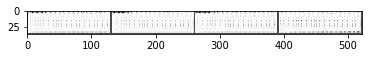

Epoch: 2, Generator Loss: 8.7244, Discriminator Loss: 0.3259, Recognizer Loss: 15.8951, AvgGenerator Loss: 8.8935, AvgDiscriminator Loss: 0.3630, AvgRecognizer Loss: 15.9723:  58%|█████▊    | 500/855 [06:38<04:37,  1.28it/s]


Labels:  ('Sam', 'This', 'that', 'monstrous')


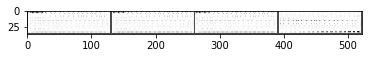

Epoch: 2, Generator Loss: 8.7526, Discriminator Loss: 0.3261, Recognizer Loss: 15.4956, AvgGenerator Loss: 8.8627, AvgDiscriminator Loss: 0.3614, AvgRecognizer Loss: 15.9125:  70%|███████   | 600/855 [07:57<03:19,  1.28it/s]


Labels:  ('104', 'she', 'other', 'sea')


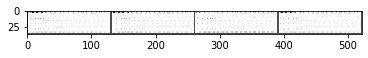

Epoch: 2, Generator Loss: 7.5769, Discriminator Loss: 0.3268, Recognizer Loss: 13.1556, AvgGenerator Loss: 8.8314, AvgDiscriminator Loss: 0.3599, AvgRecognizer Loss: 15.8538:  82%|████████▏ | 700/855 [09:17<02:02,  1.27it/s]


Labels:  ('lavish', 'wall', 'that', 'has')


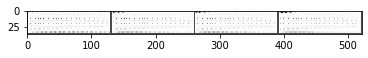

Epoch: 2, Generator Loss: 8.5735, Discriminator Loss: 0.3254, Recognizer Loss: 15.5454, AvgGenerator Loss: 8.8067, AvgDiscriminator Loss: 0.3586, AvgRecognizer Loss: 15.8055:  94%|█████████▎| 800/855 [10:37<00:43,  1.27it/s]


Labels:  ('seen', 'to', 'DARKNESS', 'every')


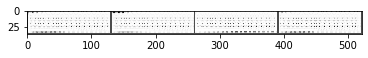

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('today', 'not', 'spoil', 'the')


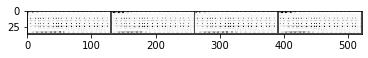

Epoch: 3, Generator Loss: 8.0273, Discriminator Loss: 0.3268, Recognizer Loss: 14.2466, AvgGenerator Loss: 8.7636, AvgDiscriminator Loss: 0.3567, AvgRecognizer Loss: 15.7215:  12%|█▏        | 100/855 [01:20<09:52,  1.27it/s]


Labels:  ('good', 'peers', 'stage', 'going')


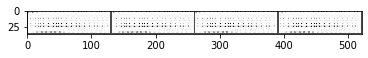

Epoch: 3, Generator Loss: 8.0276, Discriminator Loss: 0.3266, Recognizer Loss: 14.5159, AvgGenerator Loss: 8.7399, AvgDiscriminator Loss: 0.3556, AvgRecognizer Loss: 15.6745:  23%|██▎       | 200/855 [02:39<08:35,  1.27it/s]


Labels:  ('refilled', 'of', 'one', 'the')


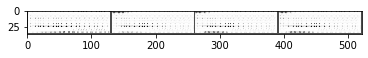

Epoch: 3, Generator Loss: 8.1980, Discriminator Loss: 0.3256, Recognizer Loss: 14.6421, AvgGenerator Loss: 8.7177, AvgDiscriminator Loss: 0.3545, AvgRecognizer Loss: 15.6294:  35%|███▌      | 300/855 [03:59<07:15,  1.28it/s]


Labels:  ('and', 'a', 'Powers', 'intervention')


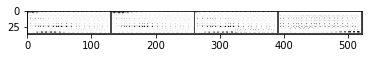

Epoch: 3, Generator Loss: 8.5942, Discriminator Loss: 0.3253, Recognizer Loss: 15.0149, AvgGenerator Loss: 8.6966, AvgDiscriminator Loss: 0.3536, AvgRecognizer Loss: 15.5860:  47%|████▋     | 400/855 [05:19<05:58,  1.27it/s]


Labels:  ('German', 'method', 'know', 'if')


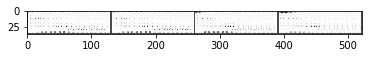

Epoch: 3, Generator Loss: 8.0338, Discriminator Loss: 0.3282, Recognizer Loss: 13.7950, AvgGenerator Loss: 8.6738, AvgDiscriminator Loss: 0.3527, AvgRecognizer Loss: 15.5374:  58%|█████▊    | 500/855 [06:38<04:39,  1.27it/s]


Labels:  ('to', 'which', 'life', 'had')


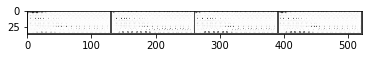

Epoch: 3, Generator Loss: 8.8046, Discriminator Loss: 0.3253, Recognizer Loss: 15.2930, AvgGenerator Loss: 8.6536, AvgDiscriminator Loss: 0.3518, AvgRecognizer Loss: 15.4938:  70%|███████   | 600/855 [07:58<03:19,  1.28it/s]


Labels:  ('each', 'to', 'and', 'the')


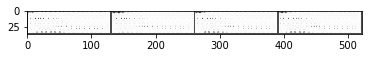

Epoch: 3, Generator Loss: 8.5514, Discriminator Loss: 0.3252, Recognizer Loss: 14.7991, AvgGenerator Loss: 8.6356, AvgDiscriminator Loss: 0.3510, AvgRecognizer Loss: 15.4523:  82%|████████▏ | 700/855 [09:18<02:01,  1.28it/s]


Labels:  ('once', 'thing', 'the', 'the')


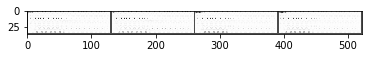

Epoch: 3, Generator Loss: 7.4084, Discriminator Loss: 0.3254, Recognizer Loss: 12.8919, AvgGenerator Loss: 8.6182, AvgDiscriminator Loss: 0.3503, AvgRecognizer Loss: 15.4130:  94%|█████████▎| 800/855 [10:37<00:43,  1.27it/s]


Labels:  ('the', 'system', '1.8', 'defence')


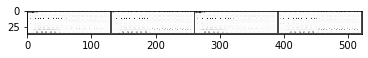

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('for', 'View', '3', 'in')


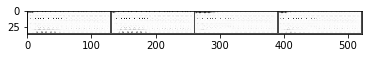

Epoch: 4, Generator Loss: 7.5386, Discriminator Loss: 0.3257, Recognizer Loss: 12.8285, AvgGenerator Loss: 8.5917, AvgDiscriminator Loss: 0.3492, AvgRecognizer Loss: 15.3497:  12%|█▏        | 100/855 [01:20<09:51,  1.28it/s]


Labels:  ('to', 'bulletins', 'anyone', 'an')


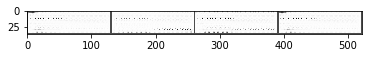

Epoch: 4, Generator Loss: 8.2508, Discriminator Loss: 0.3252, Recognizer Loss: 14.2995, AvgGenerator Loss: 8.5731, AvgDiscriminator Loss: 0.3485, AvgRecognizer Loss: 15.3050:  23%|██▎       | 200/855 [02:39<08:32,  1.28it/s]


Labels:  ('from', 'fuss-box', 'but', 'institution')


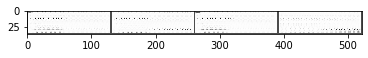

Epoch: 4, Generator Loss: 7.9109, Discriminator Loss: 0.3252, Recognizer Loss: 13.7754, AvgGenerator Loss: 8.5597, AvgDiscriminator Loss: 0.3479, AvgRecognizer Loss: 15.2703:  35%|███▌      | 300/855 [03:59<07:14,  1.28it/s]


Labels:  ('bus', 'play', 'Anglia', 'rats')


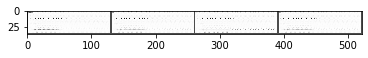

Epoch: 4, Generator Loss: 8.7343, Discriminator Loss: 0.3254, Recognizer Loss: 15.3301, AvgGenerator Loss: 8.5454, AvgDiscriminator Loss: 0.3473, AvgRecognizer Loss: 15.2316:  47%|████▋     | 400/855 [05:19<05:57,  1.27it/s]


Labels:  ('political', 'The', 'appealing', 'there')


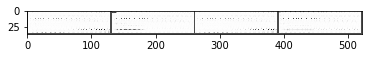

Epoch: 4, Generator Loss: 7.4795, Discriminator Loss: 0.3252, Recognizer Loss: 12.5783, AvgGenerator Loss: 8.5304, AvgDiscriminator Loss: 0.3468, AvgRecognizer Loss: 15.1907:  58%|█████▊    | 500/855 [06:38<04:37,  1.28it/s]


Labels:  ('time', 'in', 'by-', 'Tatsfield')


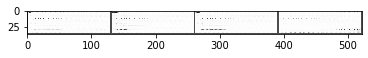

Epoch: 4, Generator Loss: 8.3830, Discriminator Loss: 0.3256, Recognizer Loss: 14.3177, AvgGenerator Loss: 8.5171, AvgDiscriminator Loss: 0.3463, AvgRecognizer Loss: 15.1536:  70%|███████   | 600/855 [07:58<03:20,  1.27it/s]


Labels:  ('contingency', 'serve', 'even', 'of')


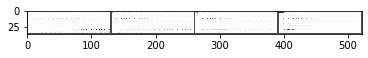

Epoch: 4, Generator Loss: 7.7705, Discriminator Loss: 0.3255, Recognizer Loss: 12.9712, AvgGenerator Loss: 8.5031, AvgDiscriminator Loss: 0.3458, AvgRecognizer Loss: 15.1138:  82%|████████▏ | 700/855 [09:18<02:01,  1.27it/s]


Labels:  ('we', 'greatest', 'you', 'Play')


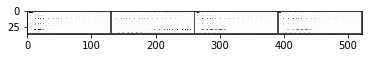

Epoch: 4, Generator Loss: 8.0356, Discriminator Loss: 0.3253, Recognizer Loss: 13.3607, AvgGenerator Loss: 8.4870, AvgDiscriminator Loss: 0.3453, AvgRecognizer Loss: 15.0693:  94%|█████████▎| 800/855 [10:38<00:43,  1.27it/s]


Labels:  ('was', 'system', 'pic-', 'The')


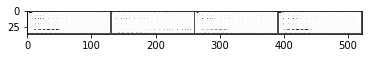

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('of', 'was', 'sown', 'money')


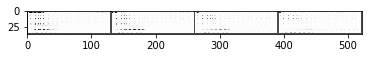

Epoch: 5, Generator Loss: 7.5355, Discriminator Loss: 0.8803, Recognizer Loss: 12.9080, AvgGenerator Loss: 8.4648, AvgDiscriminator Loss: 0.3486, AvgRecognizer Loss: 15.0102:  12%|█▏        | 100/855 [01:19<09:55,  1.27it/s]


Labels:  ('they', 'was', 'was', 'only')


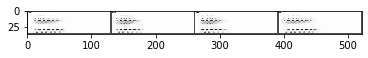

Epoch: 5, Generator Loss: 7.7881, Discriminator Loss: 0.4791, Recognizer Loss: 14.1361, AvgGenerator Loss: 8.4496, AvgDiscriminator Loss: 0.3532, AvgRecognizer Loss: 14.9762:  23%|██▎       | 200/855 [02:39<08:32,  1.28it/s]


Labels:  ('six', 'curling', 'Chiefs', 'soon')


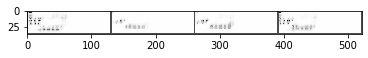

Epoch: 5, Generator Loss: 7.0071, Discriminator Loss: 0.7193, Recognizer Loss: 12.1606, AvgGenerator Loss: 8.4336, AvgDiscriminator Loss: 0.3571, AvgRecognizer Loss: 14.9381:  35%|███▌      | 300/855 [03:59<07:17,  1.27it/s]


Labels:  ('a', 'had', 'who', 'favourable')


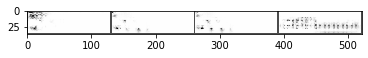

Epoch: 5, Generator Loss: 7.0678, Discriminator Loss: 0.3371, Recognizer Loss: 11.6224, AvgGenerator Loss: 8.4167, AvgDiscriminator Loss: 0.3606, AvgRecognizer Loss: 14.8995:  47%|████▋     | 400/855 [05:19<05:55,  1.28it/s]


Labels:  ('merely', 'principal', 'Anglian', 'created')


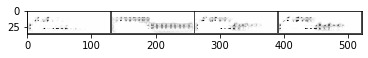

Epoch: 5, Generator Loss: 7.2725, Discriminator Loss: 0.4748, Recognizer Loss: 12.8097, AvgGenerator Loss: 8.4022, AvgDiscriminator Loss: 0.3643, AvgRecognizer Loss: 14.8667:  58%|█████▊    | 500/855 [06:39<04:40,  1.27it/s]


Labels:  ('shabby', 'is', 'as', 'as')


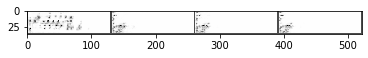

Epoch: 5, Generator Loss: 7.8116, Discriminator Loss: 0.3503, Recognizer Loss: 12.8201, AvgGenerator Loss: 8.3889, AvgDiscriminator Loss: 0.3659, AvgRecognizer Loss: 14.8292:  70%|███████   | 600/855 [07:59<03:20,  1.27it/s]


Labels:  ('to', 'for', 'the', 'from')


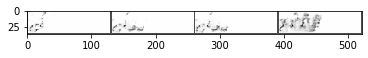

Epoch: 5, Generator Loss: 8.1721, Discriminator Loss: 0.3366, Recognizer Loss: 13.4443, AvgGenerator Loss: 8.3772, AvgDiscriminator Loss: 0.3671, AvgRecognizer Loss: 14.7921:  82%|████████▏ | 700/855 [09:19<02:02,  1.27it/s]


Labels:  ('To', 'a', 'She', 'rather')


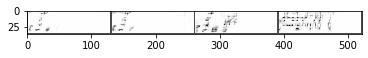

Epoch: 5, Generator Loss: 6.5007, Discriminator Loss: 0.8630, Recognizer Loss: 11.4128, AvgGenerator Loss: 8.3642, AvgDiscriminator Loss: 0.3697, AvgRecognizer Loss: 14.7549:  94%|█████████▎| 800/855 [10:38<00:43,  1.27it/s]


Labels:  ('than', 'which', "Brown's", 'is')


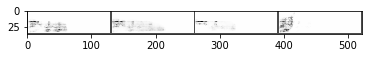

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('gently', 'on', 'populations', 'enhance')


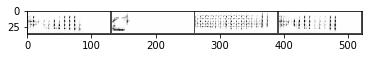

Epoch: 6, Generator Loss: 7.6690, Discriminator Loss: 0.3295, Recognizer Loss: 11.9590, AvgGenerator Loss: 8.3493, AvgDiscriminator Loss: 0.3717, AvgRecognizer Loss: 14.6997:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('was', 'God', 'him', 'how')


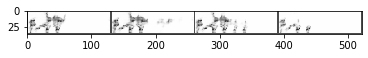

Epoch: 6, Generator Loss: 7.2808, Discriminator Loss: 0.3478, Recognizer Loss: 11.9426, AvgGenerator Loss: 8.3413, AvgDiscriminator Loss: 0.3721, AvgRecognizer Loss: 14.6642:  23%|██▎       | 200/855 [02:40<08:34,  1.27it/s]


Labels:  ('enthusiastic', 'FRIEND', 'coincided', 'Labour')


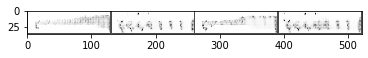

Epoch: 6, Generator Loss: 8.7669, Discriminator Loss: 0.3337, Recognizer Loss: 13.0866, AvgGenerator Loss: 8.3345, AvgDiscriminator Loss: 0.3731, AvgRecognizer Loss: 14.6335:  35%|███▌      | 300/855 [04:00<07:14,  1.28it/s]


Labels:  ('sequentially', 'pulated', 'history', 'was')


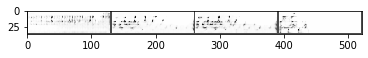

Epoch: 6, Generator Loss: 7.9288, Discriminator Loss: 0.3308, Recognizer Loss: 12.0868, AvgGenerator Loss: 8.3283, AvgDiscriminator Loss: 0.3729, AvgRecognizer Loss: 14.6016:  47%|████▋     | 400/855 [05:19<05:55,  1.28it/s]


Labels:  ('in', 'to', 'of', 'During')


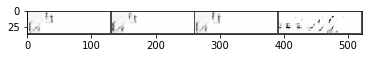

Epoch: 6, Generator Loss: 8.3006, Discriminator Loss: 0.3286, Recognizer Loss: 13.7158, AvgGenerator Loss: 8.3209, AvgDiscriminator Loss: 0.3728, AvgRecognizer Loss: 14.5673:  58%|█████▊    | 500/855 [06:39<04:38,  1.28it/s]


Labels:  ('agreement', 'the', 'British', 'younger')


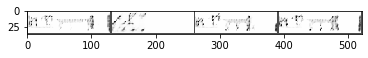

Epoch: 6, Generator Loss: 8.0874, Discriminator Loss: 0.3367, Recognizer Loss: 13.1104, AvgGenerator Loss: 8.3152, AvgDiscriminator Loss: 0.3723, AvgRecognizer Loss: 14.5342:  70%|███████   | 600/855 [07:59<03:20,  1.27it/s]


Labels:  ('2gime', 'tablecloths', 'was', 'Banking')


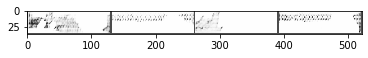

Epoch: 6, Generator Loss: 8.1862, Discriminator Loss: 0.3339, Recognizer Loss: 12.2381, AvgGenerator Loss: 8.3102, AvgDiscriminator Loss: 0.3717, AvgRecognizer Loss: 14.5025:  82%|████████▏ | 700/855 [09:19<02:02,  1.26it/s]


Labels:  ('the', "country's", 'Gamba', 'I')


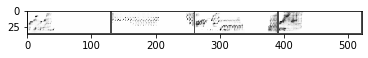

Epoch: 6, Generator Loss: 7.0635, Discriminator Loss: 0.3314, Recognizer Loss: 11.2916, AvgGenerator Loss: 8.3038, AvgDiscriminator Loss: 0.3724, AvgRecognizer Loss: 14.4709:  94%|█████████▎| 800/855 [10:39<00:43,  1.27it/s]


Labels:  ('do', 'limp', 'wash', 'made')


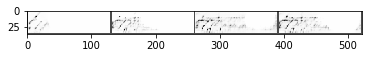

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('general', 'the', 'of', 'first')


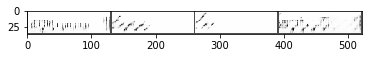

Epoch: 7, Generator Loss: 8.3986, Discriminator Loss: 1.3840, Recognizer Loss: 12.4089, AvgGenerator Loss: 8.2951, AvgDiscriminator Loss: 0.3736, AvgRecognizer Loss: 14.4233:  12%|█▏        | 100/855 [01:20<09:55,  1.27it/s]


Labels:  ('on', 'the', 'such', 'Chancellor')


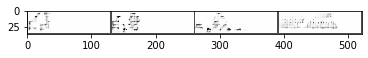

Epoch: 7, Generator Loss: 7.5825, Discriminator Loss: 0.3330, Recognizer Loss: 11.6445, AvgGenerator Loss: 8.2875, AvgDiscriminator Loss: 0.3744, AvgRecognizer Loss: 14.3912:  23%|██▎       | 200/855 [02:40<08:33,  1.28it/s]


Labels:  ('indeed', 'Cooper', 'and', 'committed')


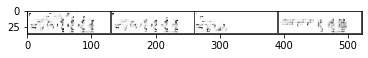

Epoch: 7, Generator Loss: 8.5808, Discriminator Loss: 0.7467, Recognizer Loss: 11.7108, AvgGenerator Loss: 8.2807, AvgDiscriminator Loss: 0.3756, AvgRecognizer Loss: 14.3611:  35%|███▌      | 300/855 [04:00<07:17,  1.27it/s]


Labels:  ('Loch', 'private', 'fine', 'clutch')


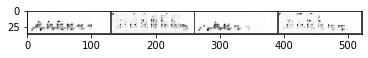

Epoch: 7, Generator Loss: 7.6226, Discriminator Loss: 0.5276, Recognizer Loss: 10.0382, AvgGenerator Loss: 8.2765, AvgDiscriminator Loss: 0.3758, AvgRecognizer Loss: 14.3327:  47%|████▋     | 400/855 [05:20<05:59,  1.27it/s]


Labels:  ('as', 'they', 'That', 'for')


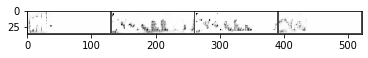

Epoch: 7, Generator Loss: 7.8991, Discriminator Loss: 0.3299, Recognizer Loss: 11.7100, AvgGenerator Loss: 8.2725, AvgDiscriminator Loss: 0.3753, AvgRecognizer Loss: 14.3039:  58%|█████▊    | 500/855 [06:39<04:40,  1.27it/s]


Labels:  ('is', 'glitter', 'holiday', 'managed')


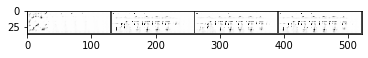

Epoch: 7, Generator Loss: 7.6997, Discriminator Loss: 0.3296, Recognizer Loss: 11.7626, AvgGenerator Loss: 8.2679, AvgDiscriminator Loss: 0.3747, AvgRecognizer Loss: 14.2737:  70%|███████   | 600/855 [07:59<03:21,  1.27it/s]


Labels:  ('possible', 'to', 'He', 'after')


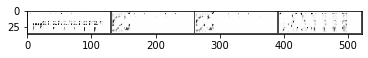

Epoch: 7, Generator Loss: 7.8621, Discriminator Loss: 0.3279, Recognizer Loss: 12.1434, AvgGenerator Loss: 8.2632, AvgDiscriminator Loss: 0.3744, AvgRecognizer Loss: 14.2453:  82%|████████▏ | 700/855 [09:19<02:01,  1.27it/s]


Labels:  ('of', 'weakness', 'the', 'of')


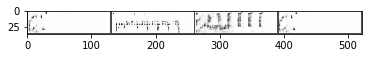

Epoch: 7, Generator Loss: 8.2252, Discriminator Loss: 0.3262, Recognizer Loss: 12.6275, AvgGenerator Loss: 8.2574, AvgDiscriminator Loss: 0.3737, AvgRecognizer Loss: 14.2155:  94%|█████████▎| 800/855 [10:39<00:43,  1.28it/s]


Labels:  ('than', 'used', 'method', 'her')


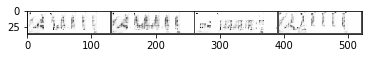

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('dishes', 'Monday', 'effect', 'and')


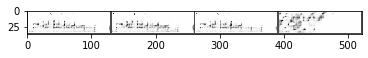

Epoch: 8, Generator Loss: 8.6409, Discriminator Loss: 0.6165, Recognizer Loss: 11.7634, AvgGenerator Loss: 8.2479, AvgDiscriminator Loss: 0.3744, AvgRecognizer Loss: 14.1710:  12%|█▏        | 100/855 [01:20<09:54,  1.27it/s]


Labels:  ('on', 'the', 'for', 'the')


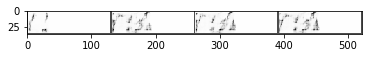

Epoch: 8, Generator Loss: 7.9322, Discriminator Loss: 0.3427, Recognizer Loss: 11.9159, AvgGenerator Loss: 8.2440, AvgDiscriminator Loss: 0.3745, AvgRecognizer Loss: 14.1426:  23%|██▎       | 200/855 [02:40<08:37,  1.27it/s]


Labels:  ('size', 'a', 'I', 'you')


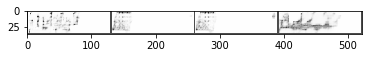

Epoch: 8, Generator Loss: 7.8305, Discriminator Loss: 0.3322, Recognizer Loss: 11.5855, AvgGenerator Loss: 8.2400, AvgDiscriminator Loss: 0.3750, AvgRecognizer Loss: 14.1133:  35%|███▌      | 300/855 [04:00<07:18,  1.27it/s]


Labels:  ('dinner', 'have', 'needs', 'time')


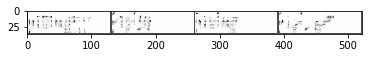

Epoch: 8, Generator Loss: 8.2076, Discriminator Loss: 0.3581, Recognizer Loss: 12.0166, AvgGenerator Loss: 8.2367, AvgDiscriminator Loss: 0.3748, AvgRecognizer Loss: 14.0838:  47%|████▋     | 400/855 [05:20<05:58,  1.27it/s]


Labels:  ('Valet', 'similar', 'be', 'was')


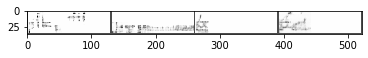

Epoch: 8, Generator Loss: 7.0453, Discriminator Loss: 0.5290, Recognizer Loss: 11.0728, AvgGenerator Loss: 8.2341, AvgDiscriminator Loss: 0.3747, AvgRecognizer Loss: 14.0542:  58%|█████▊    | 500/855 [06:40<04:38,  1.27it/s]


Labels:  ('her', 'head-stone', 'from', 'man')


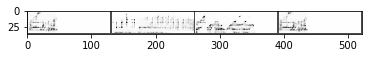

Epoch: 8, Generator Loss: 7.3281, Discriminator Loss: 0.4360, Recognizer Loss: 11.1499, AvgGenerator Loss: 8.2313, AvgDiscriminator Loss: 0.3748, AvgRecognizer Loss: 14.0263:  70%|███████   | 600/855 [08:00<03:20,  1.27it/s]


Labels:  ('shoes', 'at', 'set', 'the')


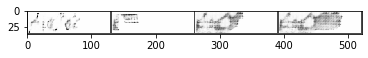

Epoch: 8, Generator Loss: 7.2713, Discriminator Loss: 0.3282, Recognizer Loss: 10.4593, AvgGenerator Loss: 8.2296, AvgDiscriminator Loss: 0.3746, AvgRecognizer Loss: 13.9999:  82%|████████▏ | 700/855 [09:20<02:01,  1.27it/s]


Labels:  ('provided', 'she', 'sounded', 'they')


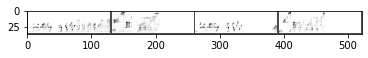

Epoch: 8, Generator Loss: 8.2006, Discriminator Loss: 0.3381, Recognizer Loss: 11.9186, AvgGenerator Loss: 8.2269, AvgDiscriminator Loss: 0.3741, AvgRecognizer Loss: 13.9733:  94%|█████████▎| 800/855 [10:40<00:43,  1.27it/s]


Labels:  ('to', 'new', "Lucas's", 'your')


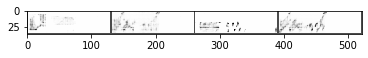

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('himself', 'also', 'a', 'thesis')


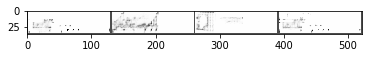

Epoch: 9, Generator Loss: 8.8844, Discriminator Loss: 0.3344, Recognizer Loss: 13.4375, AvgGenerator Loss: 8.2239, AvgDiscriminator Loss: 0.3733, AvgRecognizer Loss: 13.9331:  12%|█▏        | 100/855 [01:20<09:50,  1.28it/s]


Labels:  ('and', 'a', 'centre', 'meeting')


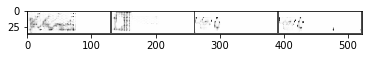

Epoch: 9, Generator Loss: 7.8175, Discriminator Loss: 0.3278, Recognizer Loss: 11.7187, AvgGenerator Loss: 8.2217, AvgDiscriminator Loss: 0.3730, AvgRecognizer Loss: 13.9055:  23%|██▎       | 200/855 [02:40<08:35,  1.27it/s]


Labels:  ('about', 'to', 'It', 'miners')


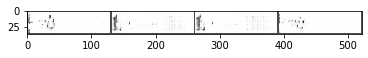

Epoch: 9, Generator Loss: 8.8372, Discriminator Loss: 0.3259, Recognizer Loss: 13.5318, AvgGenerator Loss: 8.2206, AvgDiscriminator Loss: 0.3726, AvgRecognizer Loss: 13.8798:  35%|███▌      | 300/855 [04:00<07:16,  1.27it/s]


Labels:  ('outer', 'the', 'prevent', 'by')


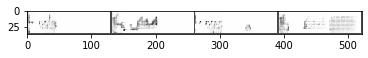

Epoch: 9, Generator Loss: 8.4584, Discriminator Loss: 0.3264, Recognizer Loss: 12.4216, AvgGenerator Loss: 8.2170, AvgDiscriminator Loss: 0.3722, AvgRecognizer Loss: 13.8511:  47%|████▋     | 400/855 [05:19<05:58,  1.27it/s]


Labels:  ('1830', 'is', 'adults', 'or')


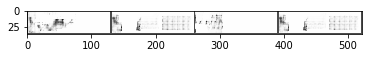

Epoch: 9, Generator Loss: 8.3492, Discriminator Loss: 0.3266, Recognizer Loss: 12.5022, AvgGenerator Loss: 8.2134, AvgDiscriminator Loss: 0.3717, AvgRecognizer Loss: 13.8234:  58%|█████▊    | 500/855 [06:39<04:40,  1.27it/s]


Labels:  ('its', 'to', 'HE', 'the')


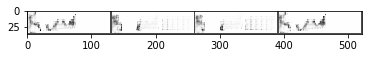

Epoch: 9, Generator Loss: 7.8081, Discriminator Loss: 0.3266, Recognizer Loss: 11.4303, AvgGenerator Loss: 8.2106, AvgDiscriminator Loss: 0.3712, AvgRecognizer Loss: 13.7965:  70%|███████   | 600/855 [07:59<03:19,  1.28it/s]


Labels:  ('was', '-', 'Dinas', 'going')


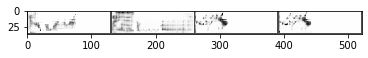

Epoch: 9, Generator Loss: 8.2192, Discriminator Loss: 0.3382, Recognizer Loss: 12.2962, AvgGenerator Loss: 8.2079, AvgDiscriminator Loss: 0.3711, AvgRecognizer Loss: 13.7704:  82%|████████▏ | 700/855 [09:19<02:01,  1.28it/s]


Labels:  ('the', 'revered', 'over', 'Appendix')


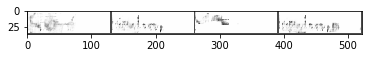

Epoch: 9, Generator Loss: 8.1720, Discriminator Loss: 0.3291, Recognizer Loss: 12.0554, AvgGenerator Loss: 8.2058, AvgDiscriminator Loss: 0.3710, AvgRecognizer Loss: 13.7432:  94%|█████████▎| 800/855 [10:39<00:43,  1.27it/s]


Labels:  ('back', 'which', 'spend', 'is')


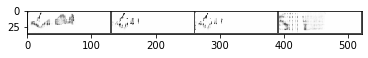

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('theodolite', 'It', 'had', 'little')


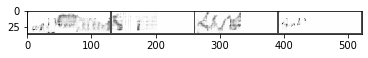

Epoch: 10, Generator Loss: 7.7836, Discriminator Loss: 0.3563, Recognizer Loss: 12.1417, AvgGenerator Loss: 8.2020, AvgDiscriminator Loss: 0.3710, AvgRecognizer Loss: 13.7007:  12%|█▏        | 100/855 [01:20<09:54,  1.27it/s]


Labels:  ('was', 'by', 'every', 'So')


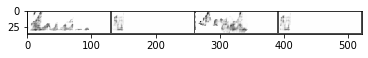

Epoch: 10, Generator Loss: 8.6099, Discriminator Loss: 0.3645, Recognizer Loss: 11.4176, AvgGenerator Loss: 8.2019, AvgDiscriminator Loss: 0.3707, AvgRecognizer Loss: 13.6756:  23%|██▎       | 200/855 [02:40<08:37,  1.27it/s]


Labels:  ('to', 'an', 'darkness', 'swimming')


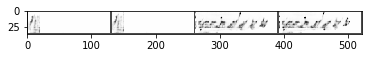

Epoch: 10, Generator Loss: 7.5130, Discriminator Loss: 0.3285, Recognizer Loss: 10.5072, AvgGenerator Loss: 8.2003, AvgDiscriminator Loss: 0.3704, AvgRecognizer Loss: 13.6482:  35%|███▌      | 300/855 [04:00<07:18,  1.27it/s]


Labels:  ('heart', 'the', 'telling', 'behind')


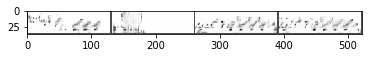

Epoch: 10, Generator Loss: 9.6651, Discriminator Loss: 0.5078, Recognizer Loss: 12.7593, AvgGenerator Loss: 8.1988, AvgDiscriminator Loss: 0.3702, AvgRecognizer Loss: 13.6226:  47%|████▋     | 400/855 [05:20<05:58,  1.27it/s]


Labels:  ('believed', 'are', 'first', 'Charles')


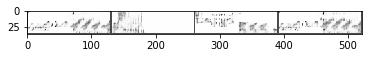

Epoch: 10, Generator Loss: 8.0172, Discriminator Loss: 0.3287, Recognizer Loss: 11.5184, AvgGenerator Loss: 8.1984, AvgDiscriminator Loss: 0.3701, AvgRecognizer Loss: 13.5984:  58%|█████▊    | 500/855 [06:40<04:40,  1.27it/s]


Labels:  ('them', 'side', 'wafted', 'did')


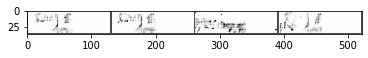

Epoch: 10, Generator Loss: 7.4395, Discriminator Loss: 0.3307, Recognizer Loss: 11.0317, AvgGenerator Loss: 8.1958, AvgDiscriminator Loss: 0.3700, AvgRecognizer Loss: 13.5726:  70%|███████   | 600/855 [08:00<03:20,  1.27it/s]


Labels:  ('have', 'interests', 'that', 'are')


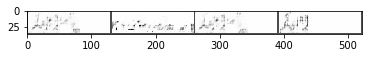

Epoch: 10, Generator Loss: 8.2631, Discriminator Loss: 0.3304, Recognizer Loss: 11.7551, AvgGenerator Loss: 8.1924, AvgDiscriminator Loss: 0.3700, AvgRecognizer Loss: 13.5454:  82%|████████▏ | 700/855 [09:20<02:02,  1.27it/s]


Labels:  ('clay', 'knowledge', 'retrospective', 'you')


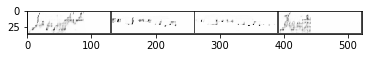

Epoch: 10, Generator Loss: 8.2094, Discriminator Loss: 0.3272, Recognizer Loss: 11.6202, AvgGenerator Loss: 8.1897, AvgDiscriminator Loss: 0.3698, AvgRecognizer Loss: 13.5197:  94%|█████████▎| 800/855 [10:40<00:43,  1.27it/s]


Labels:  ('had', 'but', 'fixed', 'nothing')


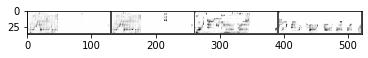

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('had', 'is', 'to', 'damaged')


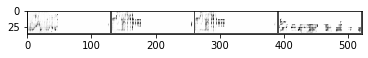

Epoch: 11, Generator Loss: 7.6555, Discriminator Loss: 0.3268, Recognizer Loss: 10.5631, AvgGenerator Loss: 8.1866, AvgDiscriminator Loss: 0.3695, AvgRecognizer Loss: 13.4804:  12%|█▏        | 100/855 [01:20<09:57,  1.26it/s]


Labels:  ('a', 'away', "'re", 'thorough')


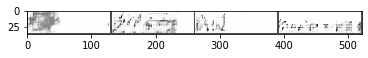

Epoch: 11, Generator Loss: 8.3176, Discriminator Loss: 0.3265, Recognizer Loss: 11.9969, AvgGenerator Loss: 8.1837, AvgDiscriminator Loss: 0.3691, AvgRecognizer Loss: 13.4545:  23%|██▎       | 200/855 [02:40<08:37,  1.27it/s]


Labels:  ('Peel', 'plunged', 'at', 'lifted')


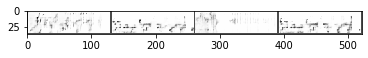

Epoch: 11, Generator Loss: 8.3724, Discriminator Loss: 0.3257, Recognizer Loss: 11.8961, AvgGenerator Loss: 8.1806, AvgDiscriminator Loss: 0.3687, AvgRecognizer Loss: 13.4283:  35%|███▌      | 300/855 [04:00<07:18,  1.26it/s]


Labels:  ('but', 'doubt', 'half', 'the')


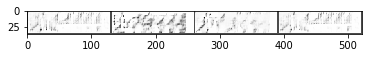

Epoch: 11, Generator Loss: 8.0733, Discriminator Loss: 0.3261, Recognizer Loss: 11.4240, AvgGenerator Loss: 8.1780, AvgDiscriminator Loss: 0.3683, AvgRecognizer Loss: 13.4037:  47%|████▋     | 400/855 [05:20<05:57,  1.27it/s]


Labels:  ('British', 'action', 'too', 'the')


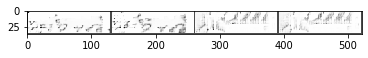

Epoch: 11, Generator Loss: 7.8860, Discriminator Loss: 0.3266, Recognizer Loss: 11.1247, AvgGenerator Loss: 8.1742, AvgDiscriminator Loss: 0.3678, AvgRecognizer Loss: 13.3775:  58%|█████▊    | 500/855 [06:40<04:40,  1.27it/s]


Labels:  ('are', 'But', 'restless', 'have')


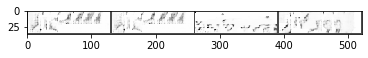

Epoch: 11, Generator Loss: 8.4341, Discriminator Loss: 0.3255, Recognizer Loss: 11.8084, AvgGenerator Loss: 8.1708, AvgDiscriminator Loss: 0.3674, AvgRecognizer Loss: 13.3517:  70%|███████   | 600/855 [08:00<03:20,  1.27it/s]


Labels:  ('grown', 'Accra', 'the', 'off')


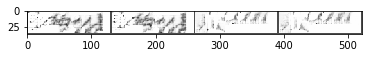

Epoch: 11, Generator Loss: 7.4883, Discriminator Loss: 0.3302, Recognizer Loss: 10.3390, AvgGenerator Loss: 8.1679, AvgDiscriminator Loss: 0.3670, AvgRecognizer Loss: 13.3274:  82%|████████▏ | 700/855 [09:20<02:02,  1.27it/s]


Labels:  ('with', 'Miss', 'wish', 'critics')


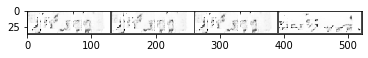

Epoch: 11, Generator Loss: 8.5877, Discriminator Loss: 0.3254, Recognizer Loss: 12.5247, AvgGenerator Loss: 8.1639, AvgDiscriminator Loss: 0.3666, AvgRecognizer Loss: 13.3016:  94%|█████████▎| 800/855 [10:40<00:43,  1.27it/s]


Labels:  ('garden', 'high', 'enough', 'others')


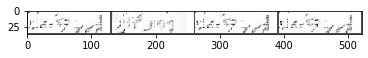

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('The', 'NO', 'Because', 'of')


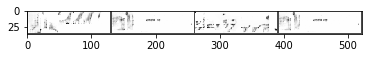

Epoch: 12, Generator Loss: 7.4099, Discriminator Loss: 0.3253, Recognizer Loss: 10.3250, AvgGenerator Loss: 8.1590, AvgDiscriminator Loss: 0.3660, AvgRecognizer Loss: 13.2636:  12%|█▏        | 100/855 [01:20<09:53,  1.27it/s]


Labels:  ('blouses', 'convictions', 'debts', 'of')


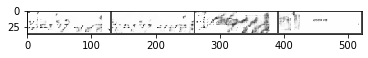

Epoch: 12, Generator Loss: 7.6723, Discriminator Loss: 0.3252, Recognizer Loss: 10.0937, AvgGenerator Loss: 8.1557, AvgDiscriminator Loss: 0.3656, AvgRecognizer Loss: 13.2391:  23%|██▎       | 200/855 [02:40<08:36,  1.27it/s]


Labels:  ('can', 'have', 'can', 'crochet')


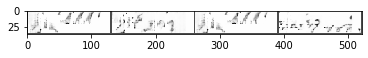

Epoch: 12, Generator Loss: 7.5279, Discriminator Loss: 0.3257, Recognizer Loss: 10.4133, AvgGenerator Loss: 8.1518, AvgDiscriminator Loss: 0.3652, AvgRecognizer Loss: 13.2141:  35%|███▌      | 300/855 [04:00<07:17,  1.27it/s]


Labels:  ('who', 'stepped', 'to', 'sacks')


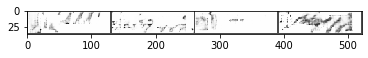

Epoch: 12, Generator Loss: 7.8719, Discriminator Loss: 0.3255, Recognizer Loss: 10.9370, AvgGenerator Loss: 8.1486, AvgDiscriminator Loss: 0.3649, AvgRecognizer Loss: 13.1901:  47%|████▋     | 400/855 [05:20<05:58,  1.27it/s]


Labels:  ('be', 'the', 'going', 'for')


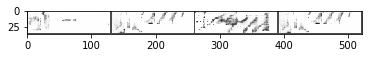

Epoch: 12, Generator Loss: 8.0412, Discriminator Loss: 0.3265, Recognizer Loss: 10.9248, AvgGenerator Loss: 8.1444, AvgDiscriminator Loss: 0.3645, AvgRecognizer Loss: 13.1646:  58%|█████▊    | 500/855 [06:40<04:40,  1.27it/s]


Labels:  ('a', 'what', 'told', 'as')


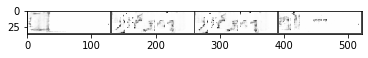

Epoch: 12, Generator Loss: 7.3344, Discriminator Loss: 0.3252, Recognizer Loss: 10.0799, AvgGenerator Loss: 8.1409, AvgDiscriminator Loss: 0.3641, AvgRecognizer Loss: 13.1406:  70%|███████   | 600/855 [08:00<03:19,  1.28it/s]


Labels:  ('Corporation', 'the', 'able', 'The')


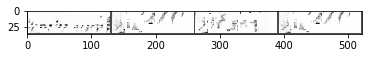

Epoch: 12, Generator Loss: 7.7545, Discriminator Loss: 0.3268, Recognizer Loss: 10.3516, AvgGenerator Loss: 8.1376, AvgDiscriminator Loss: 0.3638, AvgRecognizer Loss: 13.1170:  82%|████████▏ | 700/855 [09:20<02:01,  1.27it/s]


Labels:  ('or', 'by', 'in', 'The')


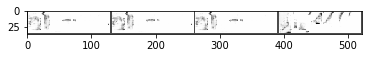

Epoch: 12, Generator Loss: 7.6198, Discriminator Loss: 0.3254, Recognizer Loss: 10.0722, AvgGenerator Loss: 8.1334, AvgDiscriminator Loss: 0.3634, AvgRecognizer Loss: 13.0915:  94%|█████████▎| 800/855 [10:40<00:43,  1.27it/s]


Labels:  ('Now', 'Miss', 'then', 'with')


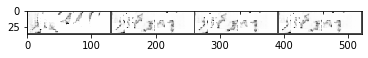

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('following', 'was', 'Peel', 'Dolce')


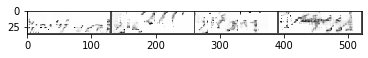

Epoch: 13, Generator Loss: 7.6308, Discriminator Loss: 0.3253, Recognizer Loss: 10.5170, AvgGenerator Loss: 8.1280, AvgDiscriminator Loss: 0.3629, AvgRecognizer Loss: 13.0545:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('where', 'own', 'of', 'Pressmen')


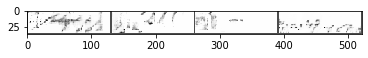

Epoch: 13, Generator Loss: 7.5603, Discriminator Loss: 0.3252, Recognizer Loss: 9.8655, AvgGenerator Loss: 8.1241, AvgDiscriminator Loss: 0.3626, AvgRecognizer Loss: 13.0297:  23%|██▎       | 200/855 [02:40<08:34,  1.27it/s]


Labels:  ('island', 'Yes', 'when', 'The')


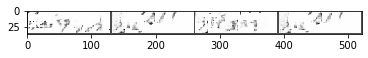

Epoch: 13, Generator Loss: 8.0985, Discriminator Loss: 0.3254, Recognizer Loss: 11.0396, AvgGenerator Loss: 8.1208, AvgDiscriminator Loss: 0.3623, AvgRecognizer Loss: 13.0061:  35%|███▌      | 300/855 [04:00<07:17,  1.27it/s]


Labels:  ('fast', 'spoke', 'two-timing', 'wife')


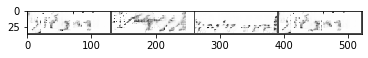

Epoch: 13, Generator Loss: 7.1045, Discriminator Loss: 0.3265, Recognizer Loss: 8.8559, AvgGenerator Loss: 8.1176, AvgDiscriminator Loss: 0.3619, AvgRecognizer Loss: 12.9824:  47%|████▋     | 400/855 [05:20<05:59,  1.27it/s]


Labels:  ('widespread', 'disciples', '-', 'believe')


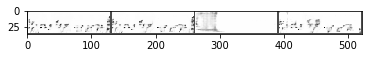

Epoch: 13, Generator Loss: 7.4622, Discriminator Loss: 0.3254, Recognizer Loss: 9.7235, AvgGenerator Loss: 8.1140, AvgDiscriminator Loss: 0.3616, AvgRecognizer Loss: 12.9593:  58%|█████▊    | 500/855 [06:40<04:41,  1.26it/s]


Labels:  ('The', 'the', 'working', 'over')


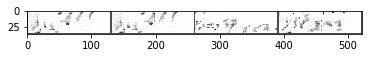

Epoch: 13, Generator Loss: 8.2710, Discriminator Loss: 0.3252, Recognizer Loss: 11.4810, AvgGenerator Loss: 8.1110, AvgDiscriminator Loss: 0.3613, AvgRecognizer Loss: 12.9365:  70%|███████   | 600/855 [08:01<03:21,  1.27it/s]


Labels:  ('recognise', 'of', 'of', 'of')


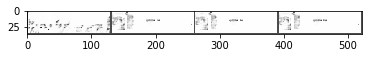

Epoch: 13, Generator Loss: 7.4534, Discriminator Loss: 0.3253, Recognizer Loss: 9.4361, AvgGenerator Loss: 8.1072, AvgDiscriminator Loss: 0.3610, AvgRecognizer Loss: 12.9124:  82%|████████▏ | 700/855 [09:21<02:02,  1.27it/s]


Labels:  ('Brown', 'their', 'uses', 'with')


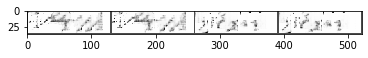

Epoch: 13, Generator Loss: 7.6693, Discriminator Loss: 0.3254, Recognizer Loss: 10.5056, AvgGenerator Loss: 8.1035, AvgDiscriminator Loss: 0.3607, AvgRecognizer Loss: 12.8886:  94%|█████████▎| 800/855 [10:41<00:43,  1.27it/s]


Labels:  ('to', 'human', 'sparked', 'out')


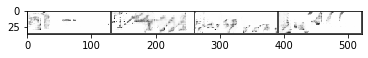

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('accounted', 'Mr.', 'loved', 'wait')


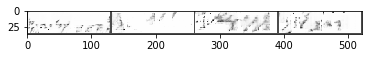

Epoch: 14, Generator Loss: 8.3977, Discriminator Loss: 0.3252, Recognizer Loss: 10.8763, AvgGenerator Loss: 8.0985, AvgDiscriminator Loss: 0.3602, AvgRecognizer Loss: 12.8524:  12%|█▏        | 100/855 [01:20<09:54,  1.27it/s]


Labels:  ('conventional', 'in', 'gives', '1.4')


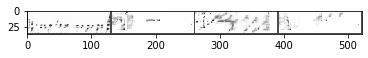

Epoch: 14, Generator Loss: 7.1582, Discriminator Loss: 0.3253, Recognizer Loss: 9.3511, AvgGenerator Loss: 8.0948, AvgDiscriminator Loss: 0.3600, AvgRecognizer Loss: 12.8286:  23%|██▎       | 200/855 [02:40<08:36,  1.27it/s]


Labels:  ('about', 'of', 'wife', 'is')


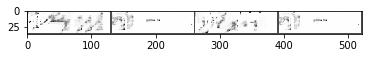

Epoch: 14, Generator Loss: 7.8452, Discriminator Loss: 0.3252, Recognizer Loss: 9.9996, AvgGenerator Loss: 8.0917, AvgDiscriminator Loss: 0.3597, AvgRecognizer Loss: 12.8059:  35%|███▌      | 300/855 [04:00<07:18,  1.27it/s]


Labels:  ('ghters', '&', 'built', 'Mart')


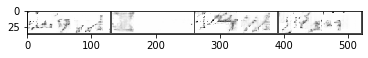

Epoch: 14, Generator Loss: 8.0347, Discriminator Loss: 0.3252, Recognizer Loss: 10.2427, AvgGenerator Loss: 8.0885, AvgDiscriminator Loss: 0.3594, AvgRecognizer Loss: 12.7827:  47%|████▋     | 400/855 [05:20<05:59,  1.27it/s]


Labels:  ('nowhere', 'that', 'Problem', 'Hahnemann')


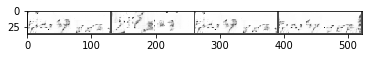

Epoch: 14, Generator Loss: 7.4380, Discriminator Loss: 0.3259, Recognizer Loss: 8.9684, AvgGenerator Loss: 8.0848, AvgDiscriminator Loss: 0.3591, AvgRecognizer Loss: 12.7595:  58%|█████▊    | 500/855 [06:40<04:40,  1.27it/s]


Labels:  ('sentiment', "Minister's", "America's", 'painful')


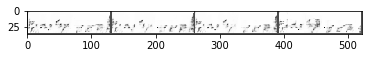

Epoch: 14, Generator Loss: 6.7869, Discriminator Loss: 0.3255, Recognizer Loss: 8.3251, AvgGenerator Loss: 8.0816, AvgDiscriminator Loss: 0.3589, AvgRecognizer Loss: 12.7367:  70%|███████   | 600/855 [08:01<03:21,  1.26it/s]


Labels:  ('smile', 'ordering', 'United', 'miserable')


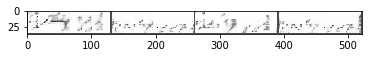

Epoch: 14, Generator Loss: 7.3777, Discriminator Loss: 0.3255, Recognizer Loss: 9.4226, AvgGenerator Loss: 8.0777, AvgDiscriminator Loss: 0.3586, AvgRecognizer Loss: 12.7123:  82%|████████▏ | 700/855 [09:21<02:02,  1.27it/s]


Labels:  ('half', 'until', 'to', 'if')


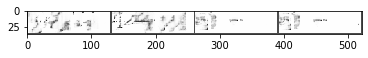

Epoch: 14, Generator Loss: 7.9357, Discriminator Loss: 0.3252, Recognizer Loss: 10.3121, AvgGenerator Loss: 8.0745, AvgDiscriminator Loss: 0.3583, AvgRecognizer Loss: 12.6901:  94%|█████████▎| 800/855 [10:41<00:43,  1.27it/s]


Labels:  ('there', 'about', 'Convention', 'or')


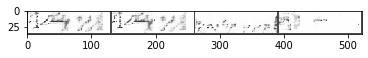

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('Maybe', 'been', 'thousands', 'We')


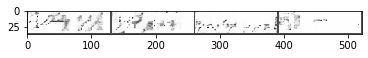

Epoch: 15, Generator Loss: 7.4064, Discriminator Loss: 0.3251, Recognizer Loss: 9.0748, AvgGenerator Loss: 8.0700, AvgDiscriminator Loss: 0.3579, AvgRecognizer Loss: 12.6555:  12%|█▏        | 100/855 [01:20<09:55,  1.27it/s]


Labels:  ('hard', 'an', 'driver', 'doctor')


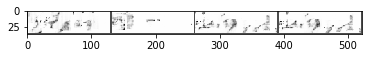

Epoch: 15, Generator Loss: 6.8505, Discriminator Loss: 0.3254, Recognizer Loss: 8.5699, AvgGenerator Loss: 8.0667, AvgDiscriminator Loss: 0.3577, AvgRecognizer Loss: 12.6330:  23%|██▎       | 200/855 [02:40<08:36,  1.27it/s]


Labels:  ('the', 'have', 'the', 'something')


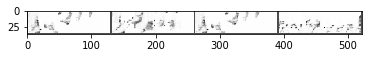

Epoch: 15, Generator Loss: 7.4827, Discriminator Loss: 0.3253, Recognizer Loss: 8.8974, AvgGenerator Loss: 8.0634, AvgDiscriminator Loss: 0.3574, AvgRecognizer Loss: 12.6099:  35%|███▌      | 300/855 [04:00<07:16,  1.27it/s]


Labels:  ('Trelawny', 'guest', 'Robbie', 'a')


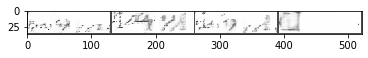

Epoch: 15, Generator Loss: 7.8490, Discriminator Loss: 0.3252, Recognizer Loss: 9.9880, AvgGenerator Loss: 8.0599, AvgDiscriminator Loss: 0.3572, AvgRecognizer Loss: 12.5869:  47%|████▋     | 400/855 [05:20<05:59,  1.27it/s]


Labels:  ('shopping', 'Monte', 'fell', 'it')


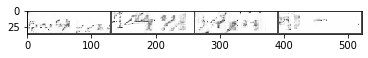

Epoch: 15, Generator Loss: 7.4059, Discriminator Loss: 0.3251, Recognizer Loss: 8.8595, AvgGenerator Loss: 8.0567, AvgDiscriminator Loss: 0.3570, AvgRecognizer Loss: 12.5647:  58%|█████▊    | 500/855 [06:41<04:40,  1.27it/s]


Labels:  ('If', 'West', 'France', 'will')


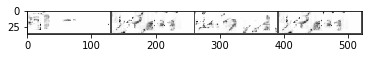

Epoch: 15, Generator Loss: 7.9627, Discriminator Loss: 0.3252, Recognizer Loss: 10.2654, AvgGenerator Loss: 8.0534, AvgDiscriminator Loss: 0.3567, AvgRecognizer Loss: 12.5422:  70%|███████   | 600/855 [08:01<03:21,  1.26it/s]


Labels:  ('would', 'god', 'was', 'of')


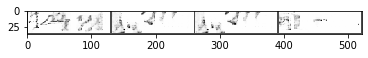

Epoch: 15, Generator Loss: 7.7943, Discriminator Loss: 0.3251, Recognizer Loss: 10.0608, AvgGenerator Loss: 8.0504, AvgDiscriminator Loss: 0.3565, AvgRecognizer Loss: 12.5205:  82%|████████▏ | 700/855 [09:21<02:02,  1.27it/s]


Labels:  ('back', 'garaged', 'expectant', 'to')


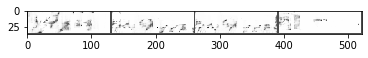

Epoch: 15, Generator Loss: 7.5975, Discriminator Loss: 0.3251, Recognizer Loss: 9.5213, AvgGenerator Loss: 8.0470, AvgDiscriminator Loss: 0.3563, AvgRecognizer Loss: 12.4989:  94%|█████████▎| 800/855 [10:41<00:43,  1.27it/s]


Labels:  ('that', 'creatures', 'or', 'was')


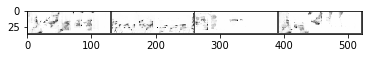

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('up', 'strength', 'a', 'same')


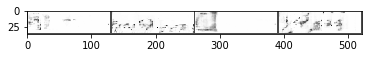

Epoch: 16, Generator Loss: 7.5028, Discriminator Loss: 0.3251, Recognizer Loss: 9.2660, AvgGenerator Loss: 8.0419, AvgDiscriminator Loss: 0.3559, AvgRecognizer Loss: 12.4645:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('that', 'and', 'thought', 'which')


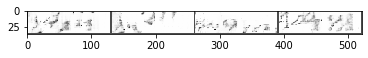

Epoch: 16, Generator Loss: 7.8037, Discriminator Loss: 0.3252, Recognizer Loss: 10.2118, AvgGenerator Loss: 8.0391, AvgDiscriminator Loss: 0.3557, AvgRecognizer Loss: 12.4427:  23%|██▎       | 200/855 [02:41<08:37,  1.27it/s]


Labels:  ('falls', 'spectacularly', 'too', 'He')


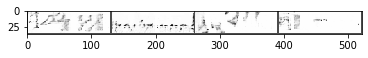

Epoch: 16, Generator Loss: 7.2589, Discriminator Loss: 0.3252, Recognizer Loss: 8.3475, AvgGenerator Loss: 8.0362, AvgDiscriminator Loss: 0.3555, AvgRecognizer Loss: 12.4213:  35%|███▌      | 300/855 [04:01<07:20,  1.26it/s]


Labels:  ('first', 'find', 'in', 'economy')


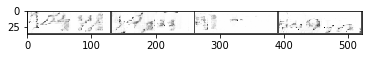

Epoch: 16, Generator Loss: 8.3322, Discriminator Loss: 0.3257, Recognizer Loss: 10.2512, AvgGenerator Loss: 8.0331, AvgDiscriminator Loss: 0.3553, AvgRecognizer Loss: 12.3996:  47%|████▋     | 400/855 [05:21<05:59,  1.27it/s]


Labels:  ('as', 'ask', 'eyes', 'the')


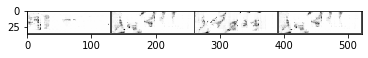

Epoch: 16, Generator Loss: 7.8276, Discriminator Loss: 0.3251, Recognizer Loss: 9.3396, AvgGenerator Loss: 8.0298, AvgDiscriminator Loss: 0.3550, AvgRecognizer Loss: 12.3780:  58%|█████▊    | 500/855 [06:41<04:40,  1.27it/s]


Labels:  ('conductor', "'m", 'stood', 'had')


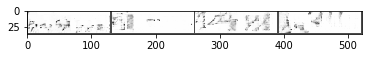

Epoch: 16, Generator Loss: 7.3715, Discriminator Loss: 0.3252, Recognizer Loss: 9.0741, AvgGenerator Loss: 8.0270, AvgDiscriminator Loss: 0.3548, AvgRecognizer Loss: 12.3573:  70%|███████   | 600/855 [08:01<03:21,  1.26it/s]


Labels:  ('be', 'a', 'students', 'and')


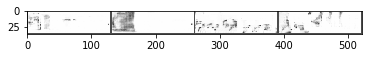

Epoch: 16, Generator Loss: 7.1439, Discriminator Loss: 0.3253, Recognizer Loss: 7.9522, AvgGenerator Loss: 8.0235, AvgDiscriminator Loss: 0.3546, AvgRecognizer Loss: 12.3351:  82%|████████▏ | 700/855 [09:21<02:02,  1.27it/s]


Labels:  ('in', 'him', 'and', 'good')


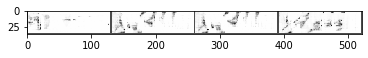

Epoch: 16, Generator Loss: 7.8152, Discriminator Loss: 0.3253, Recognizer Loss: 9.9508, AvgGenerator Loss: 8.0206, AvgDiscriminator Loss: 0.3544, AvgRecognizer Loss: 12.3138:  94%|█████████▎| 800/855 [10:41<00:43,  1.27it/s]


Labels:  ('per', 'naval', 'he', 'treated')


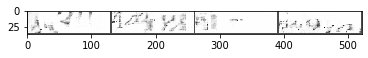

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('be', 'yet', 'Di', 'both')


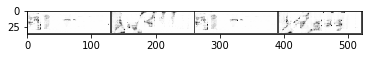

Epoch: 17, Generator Loss: 7.7034, Discriminator Loss: 0.3253, Recognizer Loss: 9.6575, AvgGenerator Loss: 8.0162, AvgDiscriminator Loss: 0.3541, AvgRecognizer Loss: 12.2814:  12%|█▏        | 100/855 [01:20<09:56,  1.26it/s]


Labels:  ('God', 'the', 'Book', 'so')


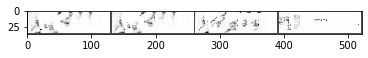

Epoch: 17, Generator Loss: 7.8675, Discriminator Loss: 0.3254, Recognizer Loss: 9.5315, AvgGenerator Loss: 8.0135, AvgDiscriminator Loss: 0.3539, AvgRecognizer Loss: 12.2610:  23%|██▎       | 200/855 [02:40<08:37,  1.27it/s]


Labels:  ('far', 'fact', 'that', 'has')


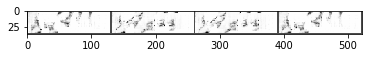

Epoch: 17, Generator Loss: 6.8712, Discriminator Loss: 0.3253, Recognizer Loss: 8.1819, AvgGenerator Loss: 8.0103, AvgDiscriminator Loss: 0.3537, AvgRecognizer Loss: 12.2393:  35%|███▌      | 300/855 [04:00<07:17,  1.27it/s]


Labels:  ('Washington', 'shops', 'give', 'greater')


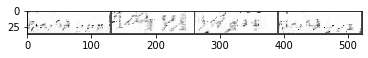

Epoch: 17, Generator Loss: 6.9133, Discriminator Loss: 0.3252, Recognizer Loss: 8.4249, AvgGenerator Loss: 8.0068, AvgDiscriminator Loss: 0.3535, AvgRecognizer Loss: 12.2174:  47%|████▋     | 400/855 [05:20<05:59,  1.26it/s]


Labels:  ('with', 'that', 'English', 'during')


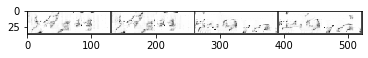

Epoch: 17, Generator Loss: 7.8003, Discriminator Loss: 0.3253, Recognizer Loss: 9.4174, AvgGenerator Loss: 8.0036, AvgDiscriminator Loss: 0.3534, AvgRecognizer Loss: 12.1963:  58%|█████▊    | 500/855 [06:40<04:39,  1.27it/s]


Labels:  ('the', 'the', 'on', 'he')


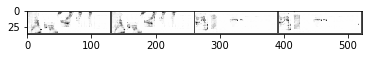

Epoch: 17, Generator Loss: 7.4604, Discriminator Loss: 0.3260, Recognizer Loss: 9.3268, AvgGenerator Loss: 8.0004, AvgDiscriminator Loss: 0.3532, AvgRecognizer Loss: 12.1754:  70%|███████   | 600/855 [08:01<03:20,  1.27it/s]


Labels:  ('lighting', 'Canada', 'also', 'and')


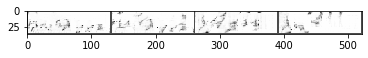

Epoch: 17, Generator Loss: 8.3508, Discriminator Loss: 0.3251, Recognizer Loss: 11.1470, AvgGenerator Loss: 7.9970, AvgDiscriminator Loss: 0.3530, AvgRecognizer Loss: 12.1535:  82%|████████▏ | 700/855 [09:21<02:02,  1.27it/s]


Labels:  ('Sunday', 'a', 'could', 'came')


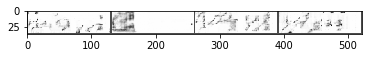

Epoch: 17, Generator Loss: 7.4099, Discriminator Loss: 0.3251, Recognizer Loss: 9.1453, AvgGenerator Loss: 7.9941, AvgDiscriminator Loss: 0.3528, AvgRecognizer Loss: 12.1329:  94%|█████████▎| 800/855 [10:41<00:43,  1.27it/s]


Labels:  ('0M', 'completely', 'shake', 'having')


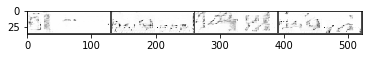

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('other', 'them', 'of', 'business')


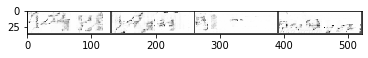

Epoch: 18, Generator Loss: 8.5498, Discriminator Loss: 0.3251, Recognizer Loss: 11.2934, AvgGenerator Loss: 7.9896, AvgDiscriminator Loss: 0.3525, AvgRecognizer Loss: 12.1015:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('with', 'and', 'an', 'thrust')


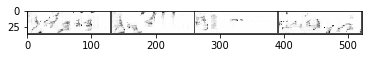

Epoch: 18, Generator Loss: 7.6095, Discriminator Loss: 0.3252, Recognizer Loss: 8.5600, AvgGenerator Loss: 7.9862, AvgDiscriminator Loss: 0.3524, AvgRecognizer Loss: 12.0799:  23%|██▎       | 200/855 [02:40<08:34,  1.27it/s]


Labels:  ('dangerous', 'Butagas', 'mass', 'payments')


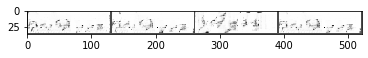

Epoch: 18, Generator Loss: 6.9221, Discriminator Loss: 0.3255, Recognizer Loss: 7.5791, AvgGenerator Loss: 7.9832, AvgDiscriminator Loss: 0.3522, AvgRecognizer Loss: 12.0595:  35%|███▌      | 300/855 [04:00<07:18,  1.27it/s]


Labels:  ('on', 'to', '1830', 'killed')


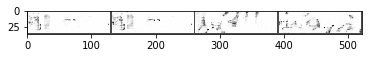

Epoch: 18, Generator Loss: 7.4272, Discriminator Loss: 0.3258, Recognizer Loss: 9.1800, AvgGenerator Loss: 7.9799, AvgDiscriminator Loss: 0.3520, AvgRecognizer Loss: 12.0384:  47%|████▋     | 400/855 [05:20<05:59,  1.27it/s]


Labels:  ('Vaughan', 'make', 'felt', 'promiscuous')


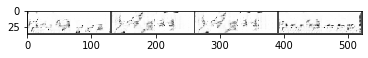

Epoch: 18, Generator Loss: 6.8464, Discriminator Loss: 0.3252, Recognizer Loss: 6.7670, AvgGenerator Loss: 7.9763, AvgDiscriminator Loss: 0.3518, AvgRecognizer Loss: 12.0170:  58%|█████▊    | 500/855 [06:41<04:40,  1.27it/s]


Labels:  ('with', 'the', 'had', 'minute')


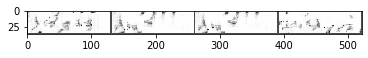

Epoch: 18, Generator Loss: 7.1192, Discriminator Loss: 0.3252, Recognizer Loss: 7.8008, AvgGenerator Loss: 7.9736, AvgDiscriminator Loss: 0.3517, AvgRecognizer Loss: 11.9971:  70%|███████   | 600/855 [08:01<03:21,  1.27it/s]


Labels:  ('Research', 'among', 'RUBBISH', 'effected')


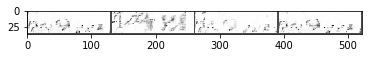

Epoch: 18, Generator Loss: 7.3378, Discriminator Loss: 0.3251, Recognizer Loss: 9.0184, AvgGenerator Loss: 7.9711, AvgDiscriminator Loss: 0.3515, AvgRecognizer Loss: 11.9774:  82%|████████▏ | 700/855 [09:21<02:02,  1.27it/s]


Labels:  ('in', 'Mr.', 'thrown', 'who')


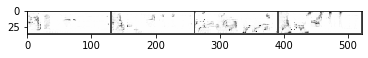

Epoch: 18, Generator Loss: 6.8349, Discriminator Loss: 0.3252, Recognizer Loss: 7.2790, AvgGenerator Loss: 7.9683, AvgDiscriminator Loss: 0.3514, AvgRecognizer Loss: 11.9576:  94%|█████████▎| 800/855 [10:41<00:43,  1.27it/s]


Labels:  ('I', 'how', 'the', "can't")


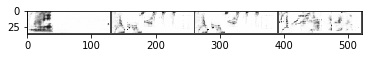

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('all', 'Sir', 'so', 'passenger')


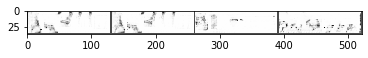

Epoch: 19, Generator Loss: 7.6971, Discriminator Loss: 0.3254, Recognizer Loss: 8.8516, AvgGenerator Loss: 7.9640, AvgDiscriminator Loss: 0.3511, AvgRecognizer Loss: 11.9265:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('to', 'waves', 'sexual', 'of')


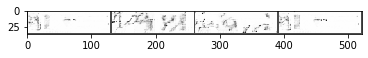

Epoch: 19, Generator Loss: 6.5803, Discriminator Loss: 0.3252, Recognizer Loss: 6.8797, AvgGenerator Loss: 7.9609, AvgDiscriminator Loss: 0.3509, AvgRecognizer Loss: 11.9065:  23%|██▎       | 200/855 [02:40<08:37,  1.27it/s]


Labels:  ('why', 'very', 'are', 'for')


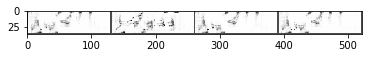

Epoch: 19, Generator Loss: 7.3618, Discriminator Loss: 0.3254, Recognizer Loss: 7.9929, AvgGenerator Loss: 7.9581, AvgDiscriminator Loss: 0.3508, AvgRecognizer Loss: 11.8865:  35%|███▌      | 300/855 [04:00<07:17,  1.27it/s]


Labels:  ('a', 'I', 'peace', 'satellite')


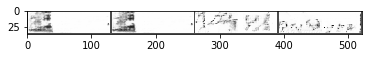

Epoch: 19, Generator Loss: 7.5281, Discriminator Loss: 0.3257, Recognizer Loss: 9.3489, AvgGenerator Loss: 7.9549, AvgDiscriminator Loss: 0.3506, AvgRecognizer Loss: 11.8662:  47%|████▋     | 400/855 [05:21<05:59,  1.27it/s]


Labels:  ('is', 'and', 'a', 'of')


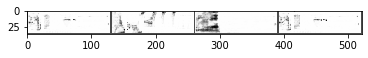

Epoch: 19, Generator Loss: 7.6307, Discriminator Loss: 0.3252, Recognizer Loss: 9.4601, AvgGenerator Loss: 7.9522, AvgDiscriminator Loss: 0.3505, AvgRecognizer Loss: 11.8467:  58%|█████▊    | 500/855 [06:41<04:40,  1.26it/s]


Labels:  ('the', 'charming', 'his', 'accompanied')


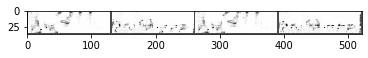

Epoch: 19, Generator Loss: 7.0456, Discriminator Loss: 0.3253, Recognizer Loss: 7.6927, AvgGenerator Loss: 7.9485, AvgDiscriminator Loss: 0.3503, AvgRecognizer Loss: 11.8257:  70%|███████   | 600/855 [08:01<03:21,  1.27it/s]


Labels:  ('planting', 'well', 'if', 'towns')


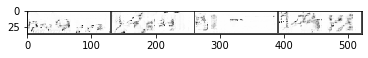

Epoch: 19, Generator Loss: 7.9813, Discriminator Loss: 0.3251, Recognizer Loss: 9.5727, AvgGenerator Loss: 7.9458, AvgDiscriminator Loss: 0.3502, AvgRecognizer Loss: 11.8066:  82%|████████▏ | 700/855 [09:21<02:01,  1.27it/s]


Labels:  ('another', 'the', 'work', 'not')


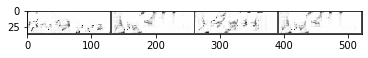

Epoch: 19, Generator Loss: 7.1530, Discriminator Loss: 0.3253, Recognizer Loss: 8.3793, AvgGenerator Loss: 7.9432, AvgDiscriminator Loss: 0.3500, AvgRecognizer Loss: 11.7879:  94%|█████████▎| 800/855 [10:41<00:43,  1.27it/s]


Labels:  ('therefore', 'the', 'poll-tax', 'stifling')


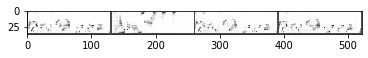

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('not', 'two', 'fidelity', 'and')


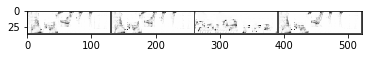

Epoch: 20, Generator Loss: 6.9286, Discriminator Loss: 0.3252, Recognizer Loss: 7.4080, AvgGenerator Loss: 7.9387, AvgDiscriminator Loss: 0.3498, AvgRecognizer Loss: 11.7573:  12%|█▏        | 100/855 [01:20<09:57,  1.26it/s]


Labels:  ('the', 'on', 'and', 'measure')


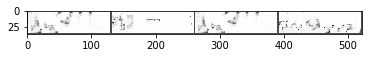

Epoch: 20, Generator Loss: 8.3358, Discriminator Loss: 0.3251, Recognizer Loss: 10.5947, AvgGenerator Loss: 7.9358, AvgDiscriminator Loss: 0.3497, AvgRecognizer Loss: 11.7381:  23%|██▎       | 200/855 [02:40<08:37,  1.27it/s]


Labels:  ('back', 'an', 'Neapolitan', 'however')


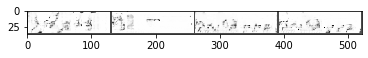

Epoch: 20, Generator Loss: 7.2191, Discriminator Loss: 0.3251, Recognizer Loss: 8.5090, AvgGenerator Loss: 7.9327, AvgDiscriminator Loss: 0.3495, AvgRecognizer Loss: 11.7181:  35%|███▌      | 300/855 [04:01<07:19,  1.26it/s]


Labels:  ('quarters', 'The', 'the', 'of')


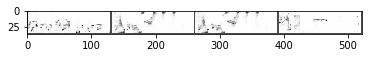

Epoch: 20, Generator Loss: 7.5273, Discriminator Loss: 0.3358, Recognizer Loss: 9.1334, AvgGenerator Loss: 7.9289, AvgDiscriminator Loss: 0.3510, AvgRecognizer Loss: 11.6987:  47%|████▋     | 400/855 [05:21<05:59,  1.27it/s]


Labels:  ('Last', 'will', 'and', 'Richards')


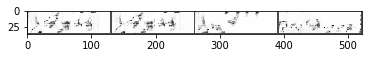

Epoch: 20, Generator Loss: 6.4566, Discriminator Loss: 0.3947, Recognizer Loss: 7.8699, AvgGenerator Loss: 7.9257, AvgDiscriminator Loss: 0.3514, AvgRecognizer Loss: 11.6795:  58%|█████▊    | 500/855 [06:41<04:40,  1.27it/s]


Labels:  ('place', 'from', 'those', 'God')


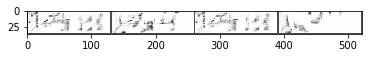

Epoch: 20, Generator Loss: 8.6112, Discriminator Loss: 0.3300, Recognizer Loss: 9.8577, AvgGenerator Loss: 7.9232, AvgDiscriminator Loss: 0.3515, AvgRecognizer Loss: 11.6594:  70%|███████   | 600/855 [08:01<03:21,  1.27it/s]


Labels:  ('against', 'of', 'that', 'to')


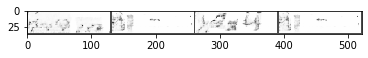

Epoch: 20, Generator Loss: 7.2020, Discriminator Loss: 0.3264, Recognizer Loss: 7.8894, AvgGenerator Loss: 7.9212, AvgDiscriminator Loss: 0.3513, AvgRecognizer Loss: 11.6403:  82%|████████▏ | 700/855 [09:21<02:02,  1.26it/s]


Labels:  ('mind', 'studied', 'in', 'degree')


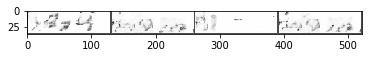

Epoch: 20, Generator Loss: 7.7782, Discriminator Loss: 0.5525, Recognizer Loss: 9.5300, AvgGenerator Loss: 7.9194, AvgDiscriminator Loss: 0.3513, AvgRecognizer Loss: 11.6217:  94%|█████████▎| 800/855 [10:41<00:43,  1.27it/s]


Labels:  ('he', 'in', 'journey', 'to')


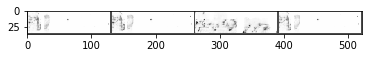

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('satisfaction', 'walls', 'high', 'gear')


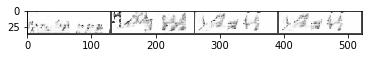

Epoch: 21, Generator Loss: 8.0699, Discriminator Loss: 0.3254, Recognizer Loss: 9.1983, AvgGenerator Loss: 7.9167, AvgDiscriminator Loss: 0.3513, AvgRecognizer Loss: 11.5930:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('courtiers', 'he', 'West', 'again')


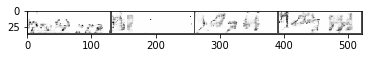

Epoch: 21, Generator Loss: 8.1586, Discriminator Loss: 0.3264, Recognizer Loss: 8.9364, AvgGenerator Loss: 7.9151, AvgDiscriminator Loss: 0.3512, AvgRecognizer Loss: 11.5742:  23%|██▎       | 200/855 [02:40<08:37,  1.27it/s]


Labels:  ('over', 'faults', 'the', 'a')


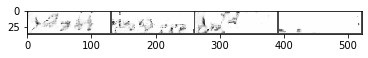

Epoch: 21, Generator Loss: 8.0943, Discriminator Loss: 0.3298, Recognizer Loss: 9.0121, AvgGenerator Loss: 7.9130, AvgDiscriminator Loss: 0.3512, AvgRecognizer Loss: 11.5553:  35%|███▌      | 300/855 [04:00<07:18,  1.26it/s]


Labels:  ('By', 'caught', 'soldier', 'by')


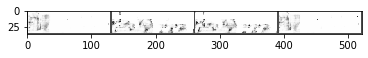

Epoch: 21, Generator Loss: 6.6206, Discriminator Loss: 0.3256, Recognizer Loss: 6.9561, AvgGenerator Loss: 7.9111, AvgDiscriminator Loss: 0.3511, AvgRecognizer Loss: 11.5368:  47%|████▋     | 400/855 [05:20<05:57,  1.27it/s]


Labels:  ('effective', 'spiv', 'would', 'have')


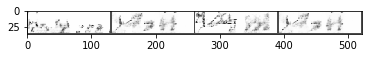

Epoch: 21, Generator Loss: 7.7242, Discriminator Loss: 0.3268, Recognizer Loss: 8.3332, AvgGenerator Loss: 7.9092, AvgDiscriminator Loss: 0.3509, AvgRecognizer Loss: 11.5182:  58%|█████▊    | 500/855 [06:41<04:42,  1.26it/s]


Labels:  ('tempt', 'the', 'the', 'But')


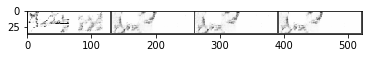

Epoch: 21, Generator Loss: 7.4435, Discriminator Loss: 0.3252, Recognizer Loss: 8.0684, AvgGenerator Loss: 7.9068, AvgDiscriminator Loss: 0.3508, AvgRecognizer Loss: 11.4994:  70%|███████   | 600/855 [08:01<03:21,  1.27it/s]


Labels:  ('and', 'as', 'due', 'of')


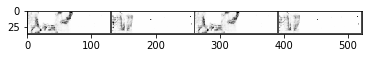

Epoch: 21, Generator Loss: 7.6102, Discriminator Loss: 0.3261, Recognizer Loss: 8.1910, AvgGenerator Loss: 7.9043, AvgDiscriminator Loss: 0.3509, AvgRecognizer Loss: 11.4808:  82%|████████▏ | 700/855 [09:21<02:03,  1.26it/s]


Labels:  ('and', 'seems', 'its', 'me')


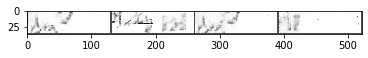

Epoch: 21, Generator Loss: 7.1849, Discriminator Loss: 0.3262, Recognizer Loss: 7.0796, AvgGenerator Loss: 7.9022, AvgDiscriminator Loss: 0.3508, AvgRecognizer Loss: 11.4619:  94%|█████████▎| 800/855 [10:41<00:43,  1.26it/s]


Labels:  ('on', 'In', 'window', 'cylindrical')


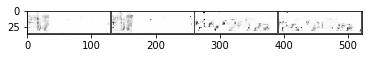

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('streets', 'with', 'led', 'by')


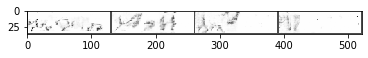

Epoch: 22, Generator Loss: 7.8191, Discriminator Loss: 0.3255, Recognizer Loss: 8.1583, AvgGenerator Loss: 7.8987, AvgDiscriminator Loss: 0.3506, AvgRecognizer Loss: 11.4330:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('in', 'sent', 'a', 'and')


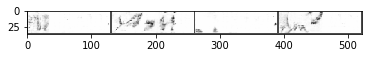

Epoch: 22, Generator Loss: 7.3533, Discriminator Loss: 0.3252, Recognizer Loss: 7.6345, AvgGenerator Loss: 7.8965, AvgDiscriminator Loss: 0.3504, AvgRecognizer Loss: 11.4148:  23%|██▎       | 200/855 [02:40<08:36,  1.27it/s]


Labels:  ('The', 'be', 'in', 'inside')


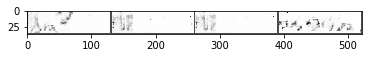

Epoch: 22, Generator Loss: 8.0656, Discriminator Loss: 0.3253, Recognizer Loss: 8.5506, AvgGenerator Loss: 7.8945, AvgDiscriminator Loss: 0.3503, AvgRecognizer Loss: 11.3971:  35%|███▌      | 300/855 [04:01<07:18,  1.26it/s]


Labels:  ('common', 'Monday', 'into', 'he')


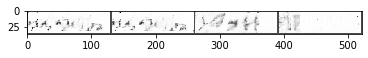

Epoch: 22, Generator Loss: 7.4952, Discriminator Loss: 0.3252, Recognizer Loss: 7.9777, AvgGenerator Loss: 7.8924, AvgDiscriminator Loss: 0.3502, AvgRecognizer Loss: 11.3791:  47%|████▋     | 400/855 [05:21<05:58,  1.27it/s]


Labels:  ('has', 'from', 'are', 'word')


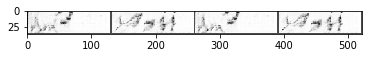

Epoch: 22, Generator Loss: 6.8548, Discriminator Loss: 0.3252, Recognizer Loss: 6.5927, AvgGenerator Loss: 7.8897, AvgDiscriminator Loss: 0.3500, AvgRecognizer Loss: 11.3603:  58%|█████▊    | 500/855 [06:41<04:40,  1.27it/s]


Labels:  ('to', 'been', 'this', 'necessary')


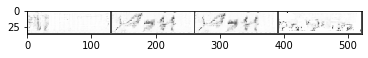

Epoch: 22, Generator Loss: 7.5640, Discriminator Loss: 0.3257, Recognizer Loss: 7.1722, AvgGenerator Loss: 7.8871, AvgDiscriminator Loss: 0.3499, AvgRecognizer Loss: 11.3419:  70%|███████   | 600/855 [08:01<03:21,  1.26it/s]


Labels:  ('there', 'promptly', '-', 'a')


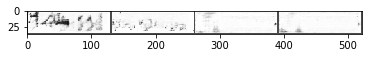

Epoch: 22, Generator Loss: 6.3430, Discriminator Loss: 0.3252, Recognizer Loss: 5.8999, AvgGenerator Loss: 7.8849, AvgDiscriminator Loss: 0.3498, AvgRecognizer Loss: 11.3239:  82%|████████▏ | 700/855 [09:21<02:02,  1.26it/s]


Labels:  ('all', 'to', 'a', 'not')


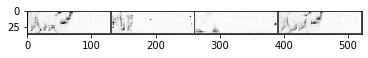

Epoch: 22, Generator Loss: 7.7872, Discriminator Loss: 0.3256, Recognizer Loss: 8.7983, AvgGenerator Loss: 7.8820, AvgDiscriminator Loss: 0.3497, AvgRecognizer Loss: 11.3055:  94%|█████████▎| 800/855 [10:42<00:43,  1.27it/s]


Labels:  ('words', 'with', 'this', 'gave')


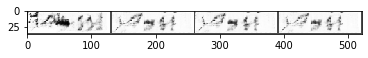

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('of', 'to', 'Top', 'change')


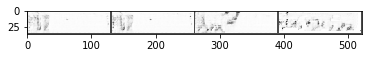

Epoch: 23, Generator Loss: 7.3013, Discriminator Loss: 0.3252, Recognizer Loss: 7.6588, AvgGenerator Loss: 7.8780, AvgDiscriminator Loss: 0.3495, AvgRecognizer Loss: 11.2773:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('could', 'this', 'tunnel', 'animosity')


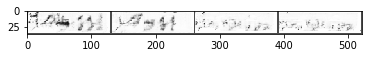

Epoch: 23, Generator Loss: 7.2330, Discriminator Loss: 0.3252, Recognizer Loss: 6.7065, AvgGenerator Loss: 7.8754, AvgDiscriminator Loss: 0.3493, AvgRecognizer Loss: 11.2591:  23%|██▎       | 200/855 [02:40<08:38,  1.26it/s]


Labels:  ('Robbie', 'into', "John's", 'iron')


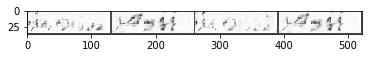

Epoch: 23, Generator Loss: 7.4060, Discriminator Loss: 0.3251, Recognizer Loss: 7.5932, AvgGenerator Loss: 7.8728, AvgDiscriminator Loss: 0.3492, AvgRecognizer Loss: 11.2414:  35%|███▌      | 300/855 [04:01<07:17,  1.27it/s]


Labels:  ('must', 'wind', 'I', 'the')


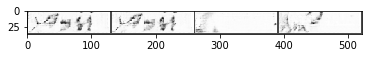

Epoch: 23, Generator Loss: 6.6217, Discriminator Loss: 0.3252, Recognizer Loss: 6.2825, AvgGenerator Loss: 7.8699, AvgDiscriminator Loss: 0.3491, AvgRecognizer Loss: 11.2229:  47%|████▋     | 400/855 [05:21<06:00,  1.26it/s]


Labels:  ('Doria', 'research', 'voice', 'negro')


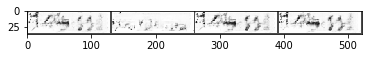

Epoch: 23, Generator Loss: 7.6216, Discriminator Loss: 0.3252, Recognizer Loss: 8.3642, AvgGenerator Loss: 7.8673, AvgDiscriminator Loss: 0.3490, AvgRecognizer Loss: 11.2052:  58%|█████▊    | 500/855 [06:41<04:40,  1.27it/s]


Labels:  ('known', 'Leipzig', 'by', 'to')


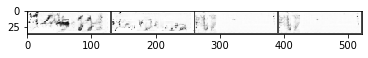

Epoch: 23, Generator Loss: 8.0734, Discriminator Loss: 0.3252, Recognizer Loss: 8.3713, AvgGenerator Loss: 7.8647, AvgDiscriminator Loss: 0.3489, AvgRecognizer Loss: 11.1877:  70%|███████   | 600/855 [08:01<03:21,  1.26it/s]


Labels:  ('worthwhile', 'action', 'with', 'she')


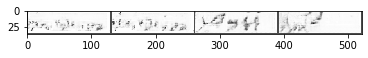

Epoch: 23, Generator Loss: 6.9729, Discriminator Loss: 0.3251, Recognizer Loss: 7.0835, AvgGenerator Loss: 7.8622, AvgDiscriminator Loss: 0.3488, AvgRecognizer Loss: 11.1705:  82%|████████▏ | 700/855 [09:21<02:02,  1.27it/s]


Labels:  ('clothing', 'party', 'how', 'his')


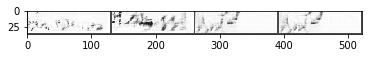

Epoch: 23, Generator Loss: 6.9926, Discriminator Loss: 0.3251, Recognizer Loss: 7.1891, AvgGenerator Loss: 7.8599, AvgDiscriminator Loss: 0.3486, AvgRecognizer Loss: 11.1538:  94%|█████████▎| 800/855 [10:42<00:43,  1.27it/s]


Labels:  ('under', 'to', 'be', 'is')


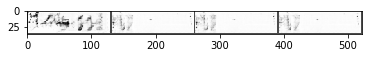

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('of', 'on', 'word', 'them')


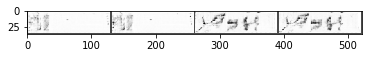

Epoch: 24, Generator Loss: 7.1404, Discriminator Loss: 0.3252, Recognizer Loss: 6.9531, AvgGenerator Loss: 7.8556, AvgDiscriminator Loss: 0.3485, AvgRecognizer Loss: 11.1261:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('of', 'hardly', 'over', 'stride')


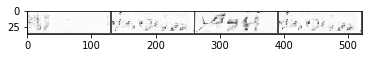

Epoch: 24, Generator Loss: 6.8801, Discriminator Loss: 0.3251, Recognizer Loss: 6.6743, AvgGenerator Loss: 7.8528, AvgDiscriminator Loss: 0.3484, AvgRecognizer Loss: 11.1084:  23%|██▎       | 200/855 [02:41<08:38,  1.26it/s]


Labels:  ('a', 'partly', 'to', 'Though')


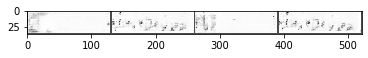

Epoch: 24, Generator Loss: 7.3766, Discriminator Loss: 0.3253, Recognizer Loss: 6.6030, AvgGenerator Loss: 7.8498, AvgDiscriminator Loss: 0.3482, AvgRecognizer Loss: 11.0905:  35%|███▌      | 300/855 [04:01<07:18,  1.27it/s]


Labels:  ('Dinsdale', 'Labour', 'after', 'very')


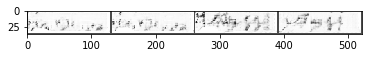

Epoch: 24, Generator Loss: 6.8895, Discriminator Loss: 0.3251, Recognizer Loss: 7.0140, AvgGenerator Loss: 7.8474, AvgDiscriminator Loss: 0.3481, AvgRecognizer Loss: 11.0737:  47%|████▋     | 400/855 [05:21<05:59,  1.27it/s]


Labels:  ('vineyards', 'court', 'without', 'they')


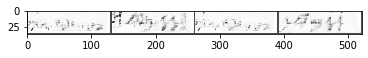

Epoch: 24, Generator Loss: 6.1523, Discriminator Loss: 0.3252, Recognizer Loss: 6.0007, AvgGenerator Loss: 7.8447, AvgDiscriminator Loss: 0.3480, AvgRecognizer Loss: 11.0567:  58%|█████▊    | 500/855 [06:41<04:40,  1.26it/s]


Labels:  ('attempt', 'yet', 'resort', 'still')


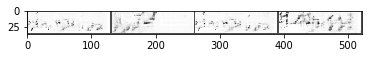

Epoch: 24, Generator Loss: 7.7881, Discriminator Loss: 0.3252, Recognizer Loss: 8.4398, AvgGenerator Loss: 7.8421, AvgDiscriminator Loss: 0.3479, AvgRecognizer Loss: 11.0396:  70%|███████   | 600/855 [08:01<03:21,  1.27it/s]


Labels:  ('and', 'was', 'by', 'a')


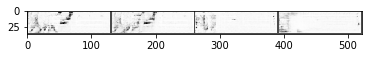

Epoch: 24, Generator Loss: 6.8693, Discriminator Loss: 0.3253, Recognizer Loss: 7.1199, AvgGenerator Loss: 7.8392, AvgDiscriminator Loss: 0.3478, AvgRecognizer Loss: 11.0224:  82%|████████▏ | 700/855 [09:22<02:02,  1.26it/s]


Labels:  ('long', 'laughter', 'breakfast-nook', 'panel')


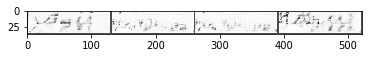

Epoch: 24, Generator Loss: 7.5837, Discriminator Loss: 0.3251, Recognizer Loss: 8.0640, AvgGenerator Loss: 7.8366, AvgDiscriminator Loss: 0.3477, AvgRecognizer Loss: 11.0057:  94%|█████████▎| 800/855 [10:42<00:43,  1.27it/s]


Labels:  ('should', 'reject', 'and', 'by')


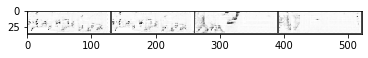

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('preoccupied', 'cigarette', 'explained', 'it')


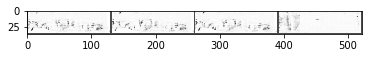

Epoch: 25, Generator Loss: 6.8786, Discriminator Loss: 0.3253, Recognizer Loss: 6.1883, AvgGenerator Loss: 7.8328, AvgDiscriminator Loss: 0.3475, AvgRecognizer Loss: 10.9799:  12%|█▏        | 100/855 [01:20<09:55,  1.27it/s]


Labels:  ('had', 'he', 'against', 'oz.')


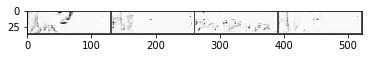

Epoch: 25, Generator Loss: 6.8672, Discriminator Loss: 0.3253, Recognizer Loss: 7.5608, AvgGenerator Loss: 7.8303, AvgDiscriminator Loss: 0.3474, AvgRecognizer Loss: 10.9630:  23%|██▎       | 200/855 [02:40<08:37,  1.27it/s]


Labels:  ('rarely', 'agreements', 'to', 'than')


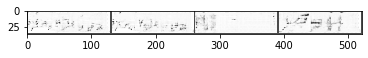

Epoch: 25, Generator Loss: 7.7480, Discriminator Loss: 0.3251, Recognizer Loss: 7.2183, AvgGenerator Loss: 7.8276, AvgDiscriminator Loss: 0.3473, AvgRecognizer Loss: 10.9457:  35%|███▌      | 300/855 [04:01<07:18,  1.27it/s]


Labels:  ('be', 'nothing', 'the', 'he')


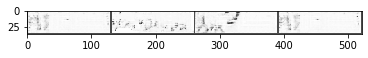

Epoch: 25, Generator Loss: 6.6138, Discriminator Loss: 0.3252, Recognizer Loss: 6.5160, AvgGenerator Loss: 7.8250, AvgDiscriminator Loss: 0.3472, AvgRecognizer Loss: 10.9293:  47%|████▋     | 400/855 [05:21<06:00,  1.26it/s]


Labels:  ('essay', 'and', 'was', 'almost')


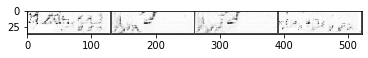

Epoch: 25, Generator Loss: 7.5403, Discriminator Loss: 0.3253, Recognizer Loss: 7.4280, AvgGenerator Loss: 7.8225, AvgDiscriminator Loss: 0.3471, AvgRecognizer Loss: 10.9126:  58%|█████▊    | 500/855 [06:41<04:40,  1.27it/s]


Labels:  ('Logan', 'what', 'boy', 'Taste')


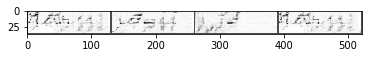

Epoch: 25, Generator Loss: 7.7184, Discriminator Loss: 0.3251, Recognizer Loss: 9.1589, AvgGenerator Loss: 7.8201, AvgDiscriminator Loss: 0.3470, AvgRecognizer Loss: 10.8964:  70%|███████   | 600/855 [08:01<03:21,  1.27it/s]


Labels:  ('between', 'hooks', "Peers'", 'which')


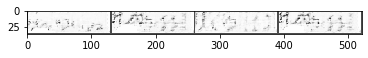

Epoch: 25, Generator Loss: 7.6485, Discriminator Loss: 0.3251, Recognizer Loss: 7.7970, AvgGenerator Loss: 7.8173, AvgDiscriminator Loss: 0.3469, AvgRecognizer Loss: 10.8796:  82%|████████▏ | 700/855 [09:22<02:02,  1.27it/s]


Labels:  ('word', 'destroying', 'of', 'if')


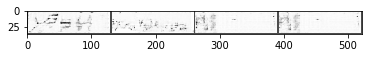

Epoch: 25, Generator Loss: 7.8588, Discriminator Loss: 0.3251, Recognizer Loss: 8.3711, AvgGenerator Loss: 7.8146, AvgDiscriminator Loss: 0.3468, AvgRecognizer Loss: 10.8629:  94%|█████████▎| 800/855 [10:42<00:43,  1.26it/s]


Labels:  ('his', 'mood', '118', 'spear')


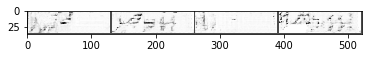

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('couples', 'poor', 'hopes', 'terms')


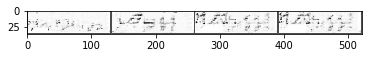

Epoch: 26, Generator Loss: 7.2255, Discriminator Loss: 0.3252, Recognizer Loss: 6.4306, AvgGenerator Loss: 7.8101, AvgDiscriminator Loss: 0.3467, AvgRecognizer Loss: 10.8361:  12%|█▏        | 100/855 [01:20<09:58,  1.26it/s]


Labels:  ('molly-coddled', 'piece', 'herself', 'I')


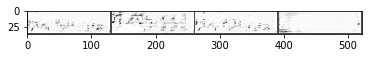

Epoch: 26, Generator Loss: 7.0341, Discriminator Loss: 0.3252, Recognizer Loss: 6.5331, AvgGenerator Loss: 7.8076, AvgDiscriminator Loss: 0.3466, AvgRecognizer Loss: 10.8198:  23%|██▎       | 200/855 [02:40<08:39,  1.26it/s]


Labels:  ('does', 'members', 'other', 'most')


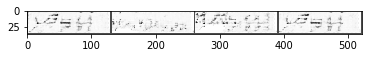

Epoch: 26, Generator Loss: 7.0045, Discriminator Loss: 0.3255, Recognizer Loss: 7.0589, AvgGenerator Loss: 7.8048, AvgDiscriminator Loss: 0.3465, AvgRecognizer Loss: 10.8034:  35%|███▌      | 300/855 [04:01<07:18,  1.27it/s]


Labels:  ('Government', 'are', 'defended', 'the')


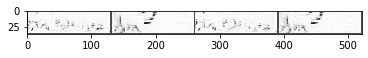

Epoch: 26, Generator Loss: 8.1176, Discriminator Loss: 0.3252, Recognizer Loss: 8.0329, AvgGenerator Loss: 7.8025, AvgDiscriminator Loss: 0.3464, AvgRecognizer Loss: 10.7877:  47%|████▋     | 400/855 [05:21<05:59,  1.26it/s]


Labels:  ('the', 'altogether', 'enable', 'report')


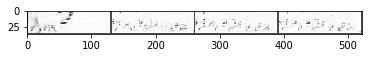

Epoch: 26, Generator Loss: 6.9210, Discriminator Loss: 0.3253, Recognizer Loss: 6.6414, AvgGenerator Loss: 7.8003, AvgDiscriminator Loss: 0.3463, AvgRecognizer Loss: 10.7721:  58%|█████▊    | 500/855 [06:41<04:40,  1.26it/s]


Labels:  ('waved', 'up', 'discuss', 'that')


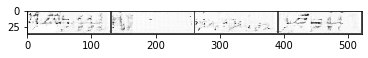

Epoch: 26, Generator Loss: 7.1040, Discriminator Loss: 0.3251, Recognizer Loss: 7.5739, AvgGenerator Loss: 7.7977, AvgDiscriminator Loss: 0.3462, AvgRecognizer Loss: 10.7560:  70%|███████   | 600/855 [08:01<03:22,  1.26it/s]


Labels:  ('and', 'effect', 'that', 'writing')


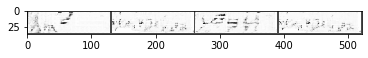

Epoch: 26, Generator Loss: 7.1803, Discriminator Loss: 0.3252, Recognizer Loss: 7.1837, AvgGenerator Loss: 7.7949, AvgDiscriminator Loss: 0.3461, AvgRecognizer Loss: 10.7397:  82%|████████▏ | 700/855 [09:22<02:03,  1.26it/s]


Labels:  ('told', 'Chambre', 'Because', 'North')


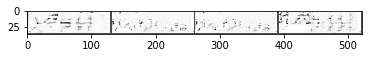

Epoch: 26, Generator Loss: 7.6205, Discriminator Loss: 0.3252, Recognizer Loss: 8.0332, AvgGenerator Loss: 7.7923, AvgDiscriminator Loss: 0.3460, AvgRecognizer Loss: 10.7238:  94%|█████████▎| 800/855 [10:42<00:43,  1.26it/s]


Labels:  ('to', 'arrived', 'to', 'of')


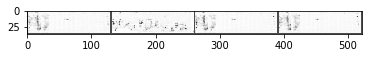

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('Fortunately', 'to', 'doleful', 'A')


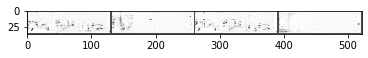

Epoch: 27, Generator Loss: 7.0074, Discriminator Loss: 0.3252, Recognizer Loss: 6.3765, AvgGenerator Loss: 7.7876, AvgDiscriminator Loss: 0.3459, AvgRecognizer Loss: 10.6978:  12%|█▏        | 100/855 [01:20<09:57,  1.26it/s]


Labels:  ('it', 'fastened', 'And', 'later')


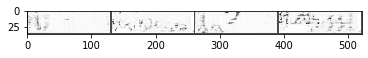

Epoch: 27, Generator Loss: 7.0854, Discriminator Loss: 0.3253, Recognizer Loss: 6.2653, AvgGenerator Loss: 7.7850, AvgDiscriminator Loss: 0.3458, AvgRecognizer Loss: 10.6814:  23%|██▎       | 200/855 [02:41<08:40,  1.26it/s]


Labels:  ('blood', 'and', 'welcomed', 'possible')


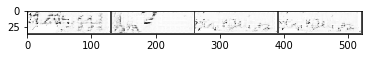

Epoch: 27, Generator Loss: 8.0852, Discriminator Loss: 0.3252, Recognizer Loss: 8.6372, AvgGenerator Loss: 7.7824, AvgDiscriminator Loss: 0.3457, AvgRecognizer Loss: 10.6655:  35%|███▌      | 300/855 [04:01<07:18,  1.27it/s]


Labels:  ('Welwyn', 'German', 'things', 'to')


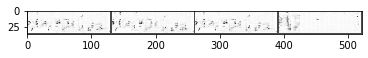

Epoch: 27, Generator Loss: 8.7209, Discriminator Loss: 0.3254, Recognizer Loss: 9.8553, AvgGenerator Loss: 7.7797, AvgDiscriminator Loss: 0.3456, AvgRecognizer Loss: 10.6498:  47%|████▋     | 400/855 [05:21<05:59,  1.26it/s]


Labels:  ('keep', 'de', 'in', 'got')


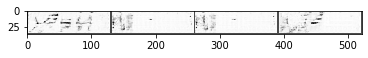

Epoch: 27, Generator Loss: 7.3327, Discriminator Loss: 0.3252, Recognizer Loss: 7.6358, AvgGenerator Loss: 7.7773, AvgDiscriminator Loss: 0.3455, AvgRecognizer Loss: 10.6339:  58%|█████▊    | 500/855 [06:41<04:40,  1.27it/s]


Labels:  ('since', 'majority', 'The', 'of')


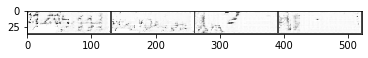

Epoch: 27, Generator Loss: 7.3166, Discriminator Loss: 0.3251, Recognizer Loss: 7.5171, AvgGenerator Loss: 7.7747, AvgDiscriminator Loss: 0.3455, AvgRecognizer Loss: 10.6186:  70%|███████   | 600/855 [08:02<03:21,  1.26it/s]


Labels:  ('to', 'pleasant', 'good', 'past')


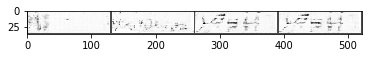

Epoch: 27, Generator Loss: 6.5061, Discriminator Loss: 0.3256, Recognizer Loss: 5.7147, AvgGenerator Loss: 7.7720, AvgDiscriminator Loss: 0.3454, AvgRecognizer Loss: 10.6030:  82%|████████▏ | 700/855 [09:22<02:02,  1.27it/s]


Labels:  ('better', 'she', 'guest', 'sea')


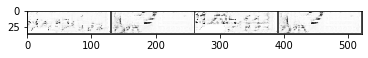

Epoch: 27, Generator Loss: 7.0825, Discriminator Loss: 0.3251, Recognizer Loss: 7.2334, AvgGenerator Loss: 7.7692, AvgDiscriminator Loss: 0.3453, AvgRecognizer Loss: 10.5875:  94%|█████████▎| 800/855 [10:42<00:43,  1.27it/s]


Labels:  ('known', 'companionship', 'of', 'When')


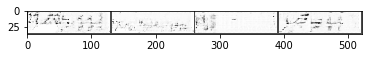

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('there', 'of', 'quantities', 'by')


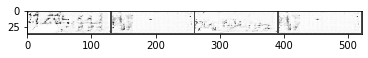

Epoch: 28, Generator Loss: 7.4261, Discriminator Loss: 0.3252, Recognizer Loss: 6.8974, AvgGenerator Loss: 7.7654, AvgDiscriminator Loss: 0.3452, AvgRecognizer Loss: 10.5634:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('long-ago', 'patient', 'of', 'is')


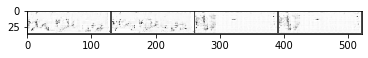

Epoch: 28, Generator Loss: 6.6993, Discriminator Loss: 0.3251, Recognizer Loss: 6.5339, AvgGenerator Loss: 7.7627, AvgDiscriminator Loss: 0.3451, AvgRecognizer Loss: 10.5476:  23%|██▎       | 200/855 [02:40<08:38,  1.26it/s]


Labels:  ('the', 'flexible', 'early', 'ruffled')


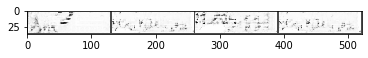

Epoch: 28, Generator Loss: 7.6272, Discriminator Loss: 0.3253, Recognizer Loss: 6.4740, AvgGenerator Loss: 7.7599, AvgDiscriminator Loss: 0.3450, AvgRecognizer Loss: 10.5314:  35%|███▌      | 300/855 [04:01<07:19,  1.26it/s]


Labels:  ('of', 'of', 'for', 'arguing')


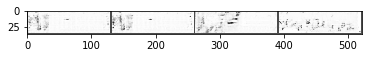

Epoch: 28, Generator Loss: 7.2348, Discriminator Loss: 0.3254, Recognizer Loss: 7.0516, AvgGenerator Loss: 7.7574, AvgDiscriminator Loss: 0.3449, AvgRecognizer Loss: 10.5160:  47%|████▋     | 400/855 [05:21<05:59,  1.26it/s]


Labels:  ('like', 'on', 'It', 'to')


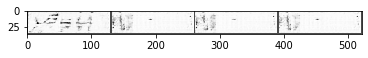

Epoch: 28, Generator Loss: 8.2083, Discriminator Loss: 0.3252, Recognizer Loss: 7.8424, AvgGenerator Loss: 7.7547, AvgDiscriminator Loss: 0.3448, AvgRecognizer Loss: 10.5004:  58%|█████▊    | 500/855 [06:41<04:40,  1.27it/s]


Labels:  ('they', 'On', 'most', 'known')


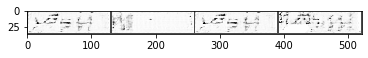

Epoch: 28, Generator Loss: 7.6744, Discriminator Loss: 0.3254, Recognizer Loss: 6.6625, AvgGenerator Loss: 7.7524, AvgDiscriminator Loss: 0.3448, AvgRecognizer Loss: 10.4857:  70%|███████   | 600/855 [08:01<03:22,  1.26it/s]


Labels:  ('controlled', 'something', 'and', 'her')


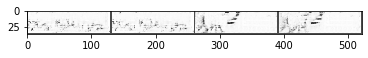

Epoch: 28, Generator Loss: 6.8190, Discriminator Loss: 0.3252, Recognizer Loss: 6.7857, AvgGenerator Loss: 7.7499, AvgDiscriminator Loss: 0.3447, AvgRecognizer Loss: 10.4705:  82%|████████▏ | 700/855 [09:22<02:02,  1.27it/s]


Labels:  ('of', 'disadvantage', 'bottle', 'a')


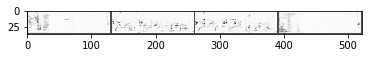

Epoch: 28, Generator Loss: 7.2173, Discriminator Loss: 0.3252, Recognizer Loss: 7.7686, AvgGenerator Loss: 7.7471, AvgDiscriminator Loss: 0.3446, AvgRecognizer Loss: 10.4553:  94%|█████████▎| 800/855 [10:42<00:43,  1.26it/s]


Labels:  ('no', 'Now', 'know', 'Goja')


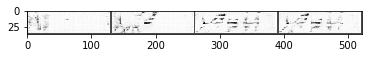

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('of', 'But', 'similar', 'on')


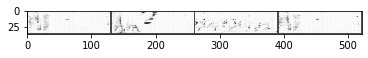

Epoch: 29, Generator Loss: 7.6270, Discriminator Loss: 0.3251, Recognizer Loss: 7.8298, AvgGenerator Loss: 7.7428, AvgDiscriminator Loss: 0.3445, AvgRecognizer Loss: 10.4313:  12%|█▏        | 100/855 [01:20<09:58,  1.26it/s]


Labels:  ('if', 'working', 'right', 'asked')


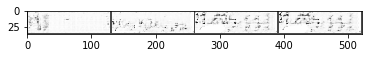

Epoch: 29, Generator Loss: 7.1669, Discriminator Loss: 0.3252, Recognizer Loss: 6.7902, AvgGenerator Loss: 7.7401, AvgDiscriminator Loss: 0.3444, AvgRecognizer Loss: 10.4157:  23%|██▎       | 200/855 [02:41<08:37,  1.27it/s]


Labels:  ('Right-Wing', 'that', 'fixed', 'our')


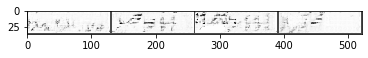

Epoch: 29, Generator Loss: 7.4502, Discriminator Loss: 0.3251, Recognizer Loss: 7.3972, AvgGenerator Loss: 7.7378, AvgDiscriminator Loss: 0.3443, AvgRecognizer Loss: 10.4009:  35%|███▌      | 300/855 [04:01<07:18,  1.27it/s]


Labels:  ('Maggie', 'which', 'like', 'to')


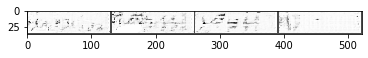

Epoch: 29, Generator Loss: 6.9148, Discriminator Loss: 0.3251, Recognizer Loss: 6.7348, AvgGenerator Loss: 7.7354, AvgDiscriminator Loss: 0.3442, AvgRecognizer Loss: 10.3861:  47%|████▋     | 400/855 [05:21<05:59,  1.27it/s]


Labels:  ('Vision', '...', 'she', 'ambition')


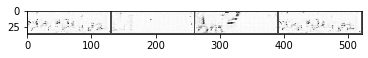

Epoch: 29, Generator Loss: 7.1191, Discriminator Loss: 0.3251, Recognizer Loss: 6.9375, AvgGenerator Loss: 7.7329, AvgDiscriminator Loss: 0.3442, AvgRecognizer Loss: 10.3710:  58%|█████▊    | 500/855 [06:42<04:40,  1.26it/s]


Labels:  ('Samuel', 'is', 'countries', 'in')


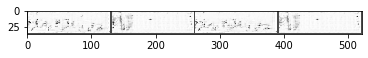

Epoch: 29, Generator Loss: 7.7898, Discriminator Loss: 0.3252, Recognizer Loss: 7.6895, AvgGenerator Loss: 7.7304, AvgDiscriminator Loss: 0.3441, AvgRecognizer Loss: 10.3562:  70%|███████   | 600/855 [08:02<03:22,  1.26it/s]


Labels:  ('on', 'up', 'Richard', 'And')


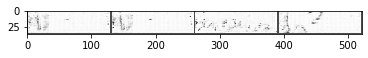

Epoch: 29, Generator Loss: 7.0678, Discriminator Loss: 0.3253, Recognizer Loss: 7.1558, AvgGenerator Loss: 7.7278, AvgDiscriminator Loss: 0.3440, AvgRecognizer Loss: 10.3416:  82%|████████▏ | 700/855 [09:22<02:02,  1.27it/s]


Labels:  ('to', 'and', 'Britain', 'as')


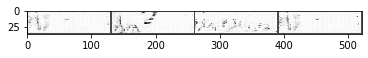

Epoch: 29, Generator Loss: 6.6560, Discriminator Loss: 0.3251, Recognizer Loss: 5.5778, AvgGenerator Loss: 7.7251, AvgDiscriminator Loss: 0.3439, AvgRecognizer Loss: 10.3266:  94%|█████████▎| 800/855 [10:43<00:43,  1.26it/s]


Labels:  ('scapegoat', 'of', 'he', 'were')


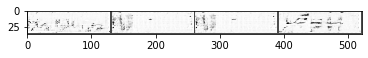

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('the', 'heat', 'serve', 'of')


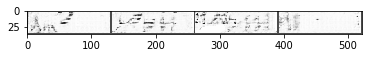

Epoch: 30, Generator Loss: 7.1422, Discriminator Loss: 0.3251, Recognizer Loss: 6.7718, AvgGenerator Loss: 7.7213, AvgDiscriminator Loss: 0.3438, AvgRecognizer Loss: 10.3034:  12%|█▏        | 100/855 [01:20<09:57,  1.26it/s]


Labels:  ('and', 'in', 'winter', 'her')


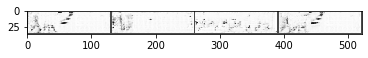

Epoch: 30, Generator Loss: 7.4260, Discriminator Loss: 0.3251, Recognizer Loss: 6.4132, AvgGenerator Loss: 7.7186, AvgDiscriminator Loss: 0.3438, AvgRecognizer Loss: 10.2885:  23%|██▎       | 200/855 [02:41<08:39,  1.26it/s]


Labels:  ('moments', 'of', 'form', 'no')


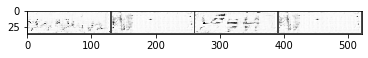

Epoch: 30, Generator Loss: 7.0453, Discriminator Loss: 0.3252, Recognizer Loss: 5.8280, AvgGenerator Loss: 7.7160, AvgDiscriminator Loss: 0.3437, AvgRecognizer Loss: 10.2733:  35%|███▌      | 300/855 [04:01<07:18,  1.27it/s]


Labels:  ('inside', 'ensure', 'a', 'wrote')


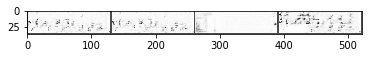

Epoch: 30, Generator Loss: 7.1372, Discriminator Loss: 0.3254, Recognizer Loss: 5.8681, AvgGenerator Loss: 7.7133, AvgDiscriminator Loss: 0.3436, AvgRecognizer Loss: 10.2582:  47%|████▋     | 400/855 [05:21<05:59,  1.26it/s]


Labels:  ('a', 'sp.', 'Mr.', 'looking')


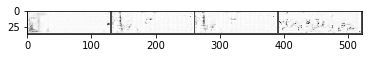

Epoch: 30, Generator Loss: 7.2518, Discriminator Loss: 0.3251, Recognizer Loss: 7.1267, AvgGenerator Loss: 7.7108, AvgDiscriminator Loss: 0.3435, AvgRecognizer Loss: 10.2439:  58%|█████▊    | 500/855 [06:41<04:40,  1.27it/s]


Labels:  ('he', 'peace', 'is', 'while')


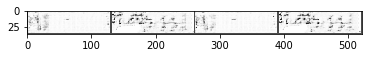

Epoch: 30, Generator Loss: 7.0134, Discriminator Loss: 0.3251, Recognizer Loss: 6.2989, AvgGenerator Loss: 7.7087, AvgDiscriminator Loss: 0.3435, AvgRecognizer Loss: 10.2297:  70%|███████   | 600/855 [08:02<03:21,  1.27it/s]


Labels:  ('gulping', 'the', 'dark-haired', 'much')


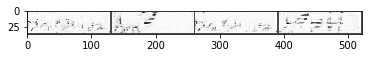

Epoch: 30, Generator Loss: 6.7293, Discriminator Loss: 0.3251, Recognizer Loss: 5.0213, AvgGenerator Loss: 7.7060, AvgDiscriminator Loss: 0.3434, AvgRecognizer Loss: 10.2149:  82%|████████▏ | 700/855 [09:22<02:03,  1.25it/s]


Labels:  ('dawn', 'last', 'Like', 'this')


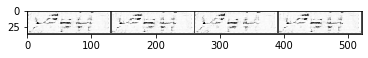

Epoch: 30, Generator Loss: 6.7650, Discriminator Loss: 0.3251, Recognizer Loss: 5.3480, AvgGenerator Loss: 7.7037, AvgDiscriminator Loss: 0.3433, AvgRecognizer Loss: 10.2009:  94%|█████████▎| 800/855 [10:42<00:43,  1.26it/s]


Labels:  ('about', 'increasing', 'I', 'had')


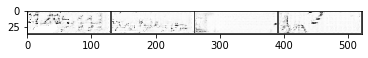

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('by', 'was', 'that', 'return')


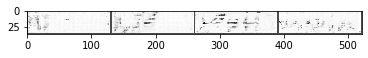

Epoch: 31, Generator Loss: 7.2471, Discriminator Loss: 0.3251, Recognizer Loss: 6.4631, AvgGenerator Loss: 7.6999, AvgDiscriminator Loss: 0.3432, AvgRecognizer Loss: 10.1783:  12%|█▏        | 100/855 [01:20<10:00,  1.26it/s]


Labels:  ('the', 'a', 'a', 'frontage')


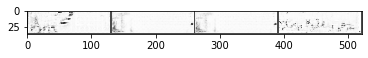

Epoch: 31, Generator Loss: 6.4358, Discriminator Loss: 0.3288, Recognizer Loss: 5.5819, AvgGenerator Loss: 7.6983, AvgDiscriminator Loss: 0.3455, AvgRecognizer Loss: 10.1636:  23%|██▎       | 200/855 [02:41<08:39,  1.26it/s]


Labels:  ('head-stones', 'Press', 'visual', 'hours')


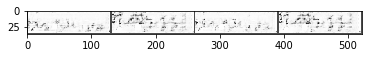

Epoch: 31, Generator Loss: 7.4425, Discriminator Loss: 0.3254, Recognizer Loss: 6.6585, AvgGenerator Loss: 7.6962, AvgDiscriminator Loss: 0.3454, AvgRecognizer Loss: 10.1489:  35%|███▌      | 300/855 [04:01<07:19,  1.26it/s]


Labels:  ('Kennedy', 'exquisite', 'Whigs', 'in')


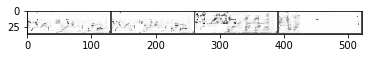

Epoch: 31, Generator Loss: 6.2688, Discriminator Loss: 0.3278, Recognizer Loss: 5.5052, AvgGenerator Loss: 7.6943, AvgDiscriminator Loss: 0.3454, AvgRecognizer Loss: 10.1348:  47%|████▋     | 400/855 [05:21<05:59,  1.26it/s]


Labels:  ('role', 'held', 'This', 'wife')


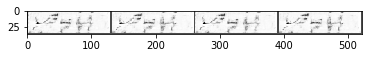

Epoch: 31, Generator Loss: 6.6763, Discriminator Loss: 0.3252, Recognizer Loss: 5.9386, AvgGenerator Loss: 7.6923, AvgDiscriminator Loss: 0.3453, AvgRecognizer Loss: 10.1207:  58%|█████▊    | 500/855 [06:41<04:41,  1.26it/s]


Labels:  ('suffering', 'departed', "wife's", 'what')


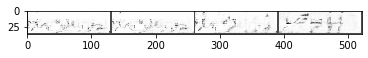

Epoch: 31, Generator Loss: 6.9485, Discriminator Loss: 0.3252, Recognizer Loss: 6.1866, AvgGenerator Loss: 7.6904, AvgDiscriminator Loss: 0.3452, AvgRecognizer Loss: 10.1065:  70%|███████   | 600/855 [08:02<03:22,  1.26it/s]


Labels:  ('of', 'which', 'stood', 'cannot')


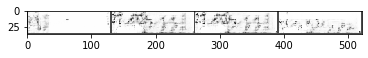

Epoch: 31, Generator Loss: 7.8715, Discriminator Loss: 0.3253, Recognizer Loss: 6.7342, AvgGenerator Loss: 7.6882, AvgDiscriminator Loss: 0.3452, AvgRecognizer Loss: 10.0924:  82%|████████▏ | 700/855 [09:22<02:03,  1.26it/s]


Labels:  ('have', 'this', 'shares', 'myself')


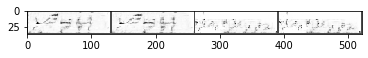

Epoch: 31, Generator Loss: 7.0160, Discriminator Loss: 0.3256, Recognizer Loss: 6.4460, AvgGenerator Loss: 7.6857, AvgDiscriminator Loss: 0.3451, AvgRecognizer Loss: 10.0781:  94%|█████████▎| 800/855 [10:43<00:43,  1.26it/s]


Labels:  ('was', 'resulted', 'carried', 'a')


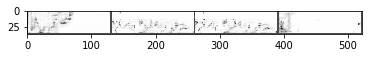

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('for', 'had', 'dark', 'responsible')


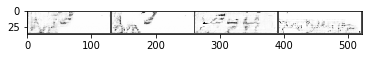

Epoch: 32, Generator Loss: 7.1200, Discriminator Loss: 0.3251, Recognizer Loss: 6.4135, AvgGenerator Loss: 7.6825, AvgDiscriminator Loss: 0.3450, AvgRecognizer Loss: 10.0563:  12%|█▏        | 100/855 [01:20<09:59,  1.26it/s]


Labels:  ('that', 'Moral', 'Nato', 'in')


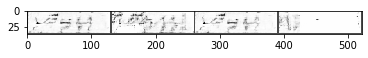

Epoch: 32, Generator Loss: 7.1935, Discriminator Loss: 0.3253, Recognizer Loss: 6.1448, AvgGenerator Loss: 7.6804, AvgDiscriminator Loss: 0.3449, AvgRecognizer Loss: 10.0418:  23%|██▎       | 200/855 [02:41<08:38,  1.26it/s]


Labels:  ('notice', 'part', 'exhausting', 'at')


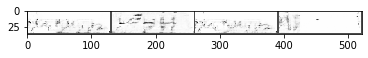

Epoch: 32, Generator Loss: 7.5757, Discriminator Loss: 0.3252, Recognizer Loss: 7.3981, AvgGenerator Loss: 7.6781, AvgDiscriminator Loss: 0.3448, AvgRecognizer Loss: 10.0277:  35%|███▌      | 300/855 [04:01<07:20,  1.26it/s]


Labels:  ('ten', 'master', 'way', 'which')


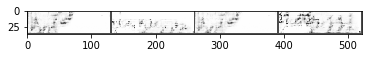

Epoch: 32, Generator Loss: 6.6811, Discriminator Loss: 0.3254, Recognizer Loss: 5.8723, AvgGenerator Loss: 7.6758, AvgDiscriminator Loss: 0.3448, AvgRecognizer Loss: 10.0132:  47%|████▋     | 400/855 [05:22<06:00,  1.26it/s]


Labels:  ('the', 'perhaps', 'point', 'WHICH')


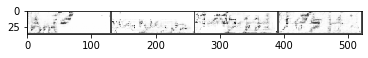

Epoch: 32, Generator Loss: 7.2391, Discriminator Loss: 0.3251, Recognizer Loss: 5.5688, AvgGenerator Loss: 7.6737, AvgDiscriminator Loss: 0.3447, AvgRecognizer Loss: 9.9992:  58%|█████▊    | 500/855 [06:42<04:40,  1.27it/s]


Labels:  ('ball', 'the', 'years', 'is')


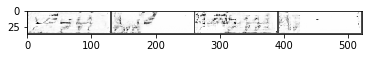

Epoch: 32, Generator Loss: 6.3237, Discriminator Loss: 0.3252, Recognizer Loss: 5.5469, AvgGenerator Loss: 7.6715, AvgDiscriminator Loss: 0.3446, AvgRecognizer Loss: 9.9854:  70%|███████   | 600/855 [08:02<03:21,  1.26it/s]


Labels:  ("wouldn't", 'died', 'than', 'have')


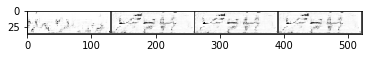

Epoch: 32, Generator Loss: 7.2948, Discriminator Loss: 0.3251, Recognizer Loss: 7.2978, AvgGenerator Loss: 7.6694, AvgDiscriminator Loss: 0.3445, AvgRecognizer Loss: 9.9716:  82%|████████▏ | 700/855 [09:23<02:02,  1.26it/s]


Labels:  ('the', 'to', 'distinguished', 'easy')


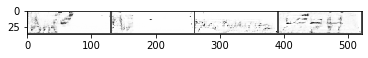

Epoch: 32, Generator Loss: 6.8603, Discriminator Loss: 0.3253, Recognizer Loss: 6.0615, AvgGenerator Loss: 7.6676, AvgDiscriminator Loss: 0.3445, AvgRecognizer Loss: 9.9588:  94%|█████████▎| 800/855 [10:43<00:43,  1.27it/s]


Labels:  ('Time', 'H-bomb', 'Edwards', 'favoured')


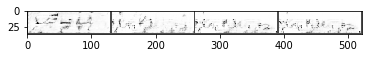

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('luxuries', 'Fell', 'still', 'wife')


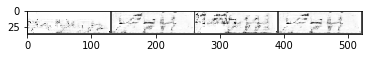

Epoch: 33, Generator Loss: 7.4677, Discriminator Loss: 0.3251, Recognizer Loss: 7.0595, AvgGenerator Loss: 7.6640, AvgDiscriminator Loss: 0.3444, AvgRecognizer Loss: 9.9369:  12%|█▏        | 100/855 [01:20<09:57,  1.26it/s]


Labels:  ('cultivated', 'the', 'a', 'leave')


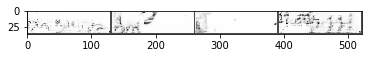

Epoch: 33, Generator Loss: 7.0264, Discriminator Loss: 0.3251, Recognizer Loss: 5.8628, AvgGenerator Loss: 7.6617, AvgDiscriminator Loss: 0.3443, AvgRecognizer Loss: 9.9228:  23%|██▎       | 200/855 [02:41<08:40,  1.26it/s]


Labels:  ('country', 'his', 'with', 'new')


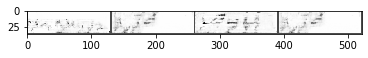

Epoch: 33, Generator Loss: 6.6810, Discriminator Loss: 0.3252, Recognizer Loss: 5.3105, AvgGenerator Loss: 7.6595, AvgDiscriminator Loss: 0.3442, AvgRecognizer Loss: 9.9086:  35%|███▌      | 300/855 [04:01<07:18,  1.26it/s]


Labels:  ('keep', 'the', 'of', 'ment')


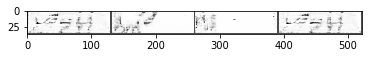

Epoch: 33, Generator Loss: 7.3901, Discriminator Loss: 0.3252, Recognizer Loss: 6.6351, AvgGenerator Loss: 7.6576, AvgDiscriminator Loss: 0.3442, AvgRecognizer Loss: 9.8952:  47%|████▋     | 400/855 [05:21<05:59,  1.26it/s]


Labels:  ('be', 'I', 'major', 'the')


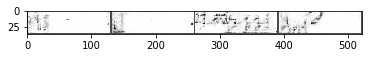

Epoch: 33, Generator Loss: 6.7932, Discriminator Loss: 0.3251, Recognizer Loss: 5.4848, AvgGenerator Loss: 7.6554, AvgDiscriminator Loss: 0.3441, AvgRecognizer Loss: 9.8815:  58%|█████▊    | 500/855 [06:41<04:40,  1.26it/s]


Labels:  ('accidental', 'put', 'its', 'the')


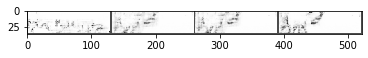

Epoch: 33, Generator Loss: 7.6605, Discriminator Loss: 0.3253, Recognizer Loss: 6.9896, AvgGenerator Loss: 7.6534, AvgDiscriminator Loss: 0.3440, AvgRecognizer Loss: 9.8680:  70%|███████   | 600/855 [08:02<03:21,  1.27it/s]


Labels:  ('the', 'he', 'on', 'the-Bomb')


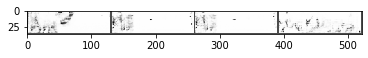

Epoch: 33, Generator Loss: 6.8409, Discriminator Loss: 0.3251, Recognizer Loss: 5.7274, AvgGenerator Loss: 7.6513, AvgDiscriminator Loss: 0.3440, AvgRecognizer Loss: 9.8546:  82%|████████▏ | 700/855 [09:22<02:02,  1.27it/s]


Labels:  ('your', 'said', 'had', 'question')


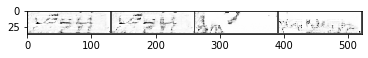

Epoch: 33, Generator Loss: 6.8348, Discriminator Loss: 0.3252, Recognizer Loss: 6.4319, AvgGenerator Loss: 7.6491, AvgDiscriminator Loss: 0.3439, AvgRecognizer Loss: 9.8414:  94%|█████████▎| 800/855 [10:42<00:43,  1.27it/s]


Labels:  ('It', 'THEM', 'the', 'me')


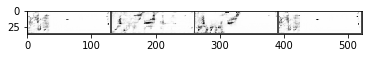

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('opposed', 'Government', 'woman', 'Byron')


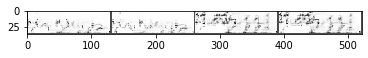

Epoch: 34, Generator Loss: 7.8520, Discriminator Loss: 0.3252, Recognizer Loss: 5.7055, AvgGenerator Loss: 7.6461, AvgDiscriminator Loss: 0.3438, AvgRecognizer Loss: 9.8204:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('quite', 'on', 'submarine', 'is')


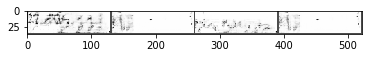

Epoch: 34, Generator Loss: 6.6845, Discriminator Loss: 0.3251, Recognizer Loss: 5.5460, AvgGenerator Loss: 7.6438, AvgDiscriminator Loss: 0.3437, AvgRecognizer Loss: 9.8066:  23%|██▎       | 200/855 [02:41<08:39,  1.26it/s]


Labels:  ('de', 'thought', 'next', 'and')


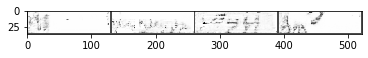

Epoch: 34, Generator Loss: 7.1729, Discriminator Loss: 0.3252, Recognizer Loss: 5.6191, AvgGenerator Loss: 7.6417, AvgDiscriminator Loss: 0.3437, AvgRecognizer Loss: 9.7932:  35%|███▌      | 300/855 [04:01<07:21,  1.26it/s]


Labels:  ('addresses', 'of', 'the', 'entirely')


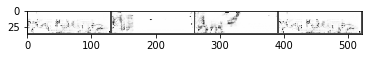

Epoch: 34, Generator Loss: 7.2403, Discriminator Loss: 0.3252, Recognizer Loss: 6.0395, AvgGenerator Loss: 7.6396, AvgDiscriminator Loss: 0.3436, AvgRecognizer Loss: 9.7799:  47%|████▋     | 400/855 [05:22<06:01,  1.26it/s]


Labels:  ('you', 'Souter', 'people', 'Nor')


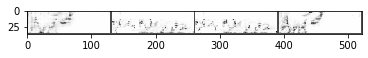

Epoch: 34, Generator Loss: 6.2579, Discriminator Loss: 0.3251, Recognizer Loss: 4.7982, AvgGenerator Loss: 7.6375, AvgDiscriminator Loss: 0.3436, AvgRecognizer Loss: 9.7667:  58%|█████▊    | 500/855 [06:42<04:40,  1.27it/s]


Labels:  ('the', 'locked', 'return', 'Byron')


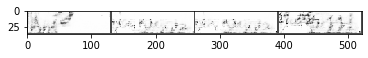

Epoch: 34, Generator Loss: 6.4413, Discriminator Loss: 0.3257, Recognizer Loss: 5.1016, AvgGenerator Loss: 7.6351, AvgDiscriminator Loss: 0.3435, AvgRecognizer Loss: 9.7533:  70%|███████   | 600/855 [08:03<03:22,  1.26it/s]


Labels:  ('cent', 'ever', 'a', 'priority')


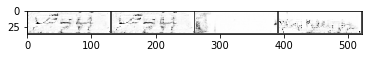

Epoch: 34, Generator Loss: 6.9451, Discriminator Loss: 0.3251, Recognizer Loss: 5.4665, AvgGenerator Loss: 7.6331, AvgDiscriminator Loss: 0.3434, AvgRecognizer Loss: 9.7401:  82%|████████▏ | 700/855 [09:23<02:03,  1.25it/s]


Labels:  ('Judge', 'less', 'a', 'of')


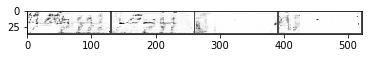

Epoch: 34, Generator Loss: 7.0683, Discriminator Loss: 0.3254, Recognizer Loss: 5.6366, AvgGenerator Loss: 7.6312, AvgDiscriminator Loss: 0.3434, AvgRecognizer Loss: 9.7274:  94%|█████████▎| 800/855 [10:44<00:43,  1.26it/s]


Labels:  ('had', 'It', 'be', 'usually')


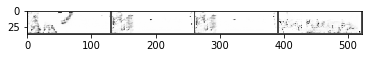

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('looking', 'height', 'was', 'braces')


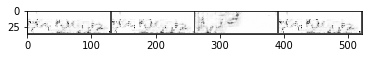

Epoch: 35, Generator Loss: 7.3257, Discriminator Loss: 0.3253, Recognizer Loss: 5.7470, AvgGenerator Loss: 7.6279, AvgDiscriminator Loss: 0.3433, AvgRecognizer Loss: 9.7069:  12%|█▏        | 100/855 [01:20<09:57,  1.26it/s]


Labels:  ('While', 'her', 'general', 'in')


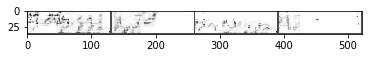

Epoch: 35, Generator Loss: 6.4470, Discriminator Loss: 0.3253, Recognizer Loss: 5.4886, AvgGenerator Loss: 7.6258, AvgDiscriminator Loss: 0.3432, AvgRecognizer Loss: 9.6934:  23%|██▎       | 200/855 [02:41<08:39,  1.26it/s]


Labels:  ('on', 'provided', 'mother', 'the')


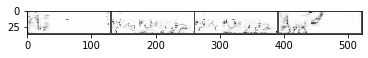

Epoch: 35, Generator Loss: 7.0321, Discriminator Loss: 0.3251, Recognizer Loss: 5.3881, AvgGenerator Loss: 7.6236, AvgDiscriminator Loss: 0.3432, AvgRecognizer Loss: 9.6801:  35%|███▌      | 300/855 [04:01<07:18,  1.26it/s]


Labels:  ('fell', 'age', 'the', 'Above')


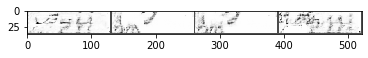

Epoch: 35, Generator Loss: 8.1368, Discriminator Loss: 0.3251, Recognizer Loss: 8.1489, AvgGenerator Loss: 7.6216, AvgDiscriminator Loss: 0.3431, AvgRecognizer Loss: 9.6672:  47%|████▋     | 400/855 [05:21<06:01,  1.26it/s]


Labels:  ('sharpness', 'a', 'two', 'separate')


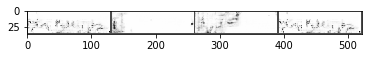

Epoch: 35, Generator Loss: 7.0831, Discriminator Loss: 0.3251, Recognizer Loss: 5.5282, AvgGenerator Loss: 7.6196, AvgDiscriminator Loss: 0.3430, AvgRecognizer Loss: 9.6546:  58%|█████▊    | 500/855 [06:42<04:41,  1.26it/s]


Labels:  ('John', 'a', 'such', 'was')


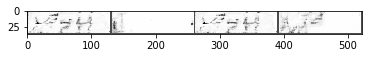

Epoch: 35, Generator Loss: 7.1759, Discriminator Loss: 0.3251, Recognizer Loss: 5.8059, AvgGenerator Loss: 7.6172, AvgDiscriminator Loss: 0.3430, AvgRecognizer Loss: 9.6413:  70%|███████   | 600/855 [08:02<03:22,  1.26it/s]


Labels:  ('confined', 'done', 'to', 'from')


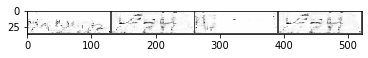

Epoch: 35, Generator Loss: 6.5481, Discriminator Loss: 0.3251, Recognizer Loss: 4.9030, AvgGenerator Loss: 7.6153, AvgDiscriminator Loss: 0.3429, AvgRecognizer Loss: 9.6285:  82%|████████▏ | 700/855 [09:22<02:03,  1.26it/s]


Labels:  ('against', 'And', 'the', 'Do')


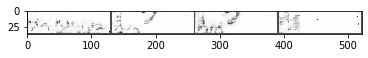

Epoch: 35, Generator Loss: 6.8272, Discriminator Loss: 0.3252, Recognizer Loss: 5.6724, AvgGenerator Loss: 7.6133, AvgDiscriminator Loss: 0.3429, AvgRecognizer Loss: 9.6159:  94%|█████████▎| 800/855 [10:43<00:43,  1.26it/s]


Labels:  ('high', 'there', 'on', 'Why')


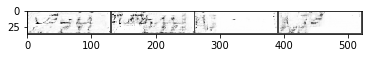

  0%|          | 0/855 [00:00<?, ?it/s]


Labels:  ('common', 'writers', 'the', 'their')


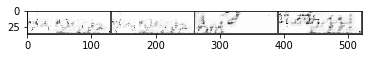

Epoch: 36, Generator Loss: 7.0785, Discriminator Loss: 0.3251, Recognizer Loss: 5.7088, AvgGenerator Loss: 7.6100, AvgDiscriminator Loss: 0.3428, AvgRecognizer Loss: 9.5954:  12%|█▏        | 100/855 [01:20<09:56,  1.27it/s]


Labels:  ('able', 'and', 'duty', 'had')


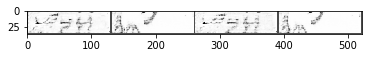

Epoch: 36, Generator Loss: 7.7577, Discriminator Loss: 0.3251, Recognizer Loss: 6.3640, AvgGenerator Loss: 7.6076, AvgDiscriminator Loss: 0.3427, AvgRecognizer Loss: 9.5820:  23%|██▎       | 200/855 [02:40<08:41,  1.26it/s]


Labels:  ('Russell', 'for', 'honesty', 'clay')


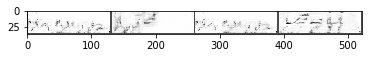

Epoch: 36, Generator Loss: 7.3304, Discriminator Loss: 0.3251, Recognizer Loss: 6.1151, AvgGenerator Loss: 7.6056, AvgDiscriminator Loss: 0.3427, AvgRecognizer Loss: 9.5688:  35%|███▌      | 300/855 [04:01<07:18,  1.27it/s]


Labels:  ('with', 'found', '1905', 'His')


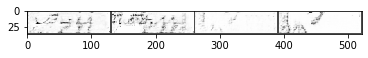

Epoch: 36, Generator Loss: 6.5563, Discriminator Loss: 0.3254, Recognizer Loss: 4.8787, AvgGenerator Loss: 7.6036, AvgDiscriminator Loss: 0.3426, AvgRecognizer Loss: 9.5558:  47%|████▋     | 400/855 [05:21<05:59,  1.26it/s]


Labels:  ('357million', 'could', 'the', "'em")


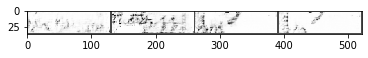

Epoch: 36, Generator Loss: 6.2918, Discriminator Loss: 0.3252, Recognizer Loss: 5.1417, AvgGenerator Loss: 7.6015, AvgDiscriminator Loss: 0.3426, AvgRecognizer Loss: 9.5431:  58%|█████▊    | 500/855 [06:41<04:41,  1.26it/s]


Labels:  ('But', 'national', 'but', 'in')


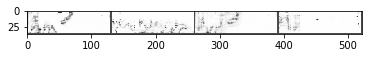

Epoch: 36, Generator Loss: 6.8511, Discriminator Loss: 0.3256, Recognizer Loss: 5.4598, AvgGenerator Loss: 7.5994, AvgDiscriminator Loss: 0.3425, AvgRecognizer Loss: 9.5307:  70%|███████   | 600/855 [08:02<03:21,  1.27it/s]


Labels:  ('Whitehall', 'symptoms', 'have', 'to')


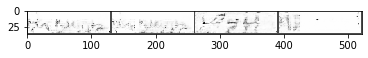

Epoch: 36, Generator Loss: 7.1795, Discriminator Loss: 0.3254, Recognizer Loss: 6.2086, AvgGenerator Loss: 7.5979, AvgDiscriminator Loss: 0.3425, AvgRecognizer Loss: 9.5200:  80%|████████  | 685/855 [09:10<02:14,  1.26it/s]

---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
/usr/local/lib/python3.6/dist-packages/torch/tensor.py in backward(self=tensor(6.6894, device='cuda:0', grad_fn=<MulBackward0>), gradient=None, retain_graph=None, create_graph=False)
    193                 products. Defaults to ``False``.
    194         """
--> 195         torch.autograd.backward(self, gradient, retain_graph, create_graph)
        global torch.autograd.backward = <function backward at 0x7f0254fddd90>
        self = tensor(6.6894, device='cuda:0', grad_fn=<MulBackward0>)
        gradient = None
        retain_graph = None
        create_graph = False
    196 
    197     def register_hook(self, hook):

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py in backward(tensors=(tensor(6.6894, device='cuda:0', grad_fn=<MulBackward0>),), grad_tensors=(tensor(1., device='cuda:0'),), retain_graph=False, create_gr

In [40]:
generator, recognizer, discriminator, g_losses, d_losses, r_losses = train()

In [0]:
torch.save(generator.state_dict(), 'generator.model')
torch.save(discriminator.state_dict(), 'discriminator.model')
torch.save(recognizer.state_dict(), 'recognizer.model')

In [42]:
!ls

discriminator.model  generator.model  labels.csv	sample_data
drive		     images	      recognizer.model


In [0]:
!cp "/content/generator.model" "drive/My Drive/datasets/"
!cp "/content/discriminator.model" "drive/My Drive/datasets/"
!cp "/content/recognizer.model" "drive/My Drive/datasets/"

In [0]:
np.savetxt('g_losses', g_losses)
np.savetxt('d_losses', d_losses)
np.savetxt('r_losses', r_losses)

In [0]:
!cp "/content/g_losses" "drive/My Drive/datasets/"
!cp "/content/d_losses" "drive/My Drive/datasets/"
!cp "/content/r_losses" "drive/My Drive/datasets/"

discriminator.model  drive	      g_losses	labels.csv	  r_losses
d_losses	     generator.model  images	recognizer.model  sample_data


Thoughts for why this may not be working:

* Loss from Recognizer is overpowering the loss the discriminator
* Not enough training time?
* Investigate Hinge-Loss
* Add Spectral Normalization
* Train all networks equally with 2e-4
* Apply gradient balancing
* Implement gradient clipping
* Re-investigate implementation of Conditional Batch Norm

## Results

In [0]:
imgs = generator(torch.randn(1, 100, 1, 1).cuda())
show_imgs(imgs)

## Old Code

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, conv=nn.Conv2d, stride=1, padding=1, kernel=3, activation=nn.LeakyReLU):
    super(ResidualBlock, self).__init__()

    self.conv1 = conv(in_channels, out_channels, kernel_size=kernel, padding=padding, stride=stride)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.act1 = activation()
    self.conv2 = conv(out_channels, out_channels, kernel_size=kernel, padding=padding, stride=stride)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.act2 = activation()
    
    if in_channels != out_channels:
      self.needs_shortcut = True
      self.conv_short = conv(in_channels, out_channels, kernel_size=kernel, padding=padding, stride=stride, bias=False)
      self.bn_short = nn.BatchNorm2d(out_channels)
      self.shortcut = nn.Sequential(
        self.conv_short,
        self.bn_short
      )
 
    else:
      self.needs_shortcut = False
  
  def forward(self, x):
    identity = x if not self.needs_shortcut else self.shortcut(x)
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.act1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.act2(out)

    if identity.shape[2] != out.shape[2]:
      identity = F.interpolate(identity, size=out.shape[2])

    out += identity

    return out

In [0]:
class Generator2(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

In [0]:
class Discriminator2(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x.squeeze()

In [0]:
def train():
  try:
    NUM_EPOCHS = 100
    BATCH_SIZE = 500
    RATIO = 3 # How many times will we train the generator for each time we train the discriminator
    IMG_ITERATIONS = 100 # Show example generator image after how many iterations

    dataset = IamDataset()

    generator = Generator()
    generator.weight_init(0, .02)
    generator = generator.cuda()

    discriminator = Discriminator()
    discriminator.weight_init(0, .02)
    discriminator = discriminator.cuda()

    print('\nGenerator: ', parameter_count(generator))
    print('Discriminator: ', parameter_count(discriminator))

    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=4e-4, betas=(0.5, 0.999))

    disc_objective = nn.BCELoss()
    gen_objective = nn.BCELoss()

    d_losses = []
    g_losses = []

    for epoch in range(NUM_EPOCHS):

      loop = tqdm(total=len(data_loader), position=0, leave=False)

      for batch, (real_images, real_transcriptions) in enumerate(data_loader):
        real_images = real_images.cuda(async=True)

        # Create labels for real/fake images
        fake_labels = torch.full((real_images.shape[0], 1), .1).squeeze().cuda() # Label Smoothing .1 -> fake_labels, .9 -> real_labels
        real_labels = torch.full((real_images.shape[0], 1), .9).squeeze().cuda()

        generator.zero_grad()
        discriminator.zero_grad()

        # Sample from latent vector
        z = torch.randn(real_images.shape[0], 100, 1, 1).cuda()
        fake_images = generator(z)
  
        # Train Generator

        gen_optimizer.zero_grad()

        fake_pred = discriminator(fake_images)
        gen_loss = gen_objective(fake_pred, real_labels) # The generator should be trying to generate real images

        g_losses.append(gen_loss.item())

        gen_loss.backward()
        gen_optimizer.step()

        # Train Discriminator
        if batch % RATIO == 0:
          disc_optimizer.zero_grad()

          fake_pred = discriminator(fake_images.detach()) # Detach so we aren't training the generator
          real_pred = discriminator(real_images)

          fake_loss = disc_objective(fake_pred, fake_labels)
          real_loss = disc_objective(real_pred, real_labels)
          disc_loss = 0.5 * (fake_loss + real_loss)

          d_losses.append(disc_loss.item())

          disc_loss.backward()
          disc_optimizer.step()
        
        if batch % IMG_ITERATIONS == 0:
          show_imgs(fake_images[:4])
          plt.pause(1)

        loop.set_description('Epoch: {}, Discriminator Loss: {:.4f}, Generator Loss: {:.4f}, AvgDiscriminator Loss: {:.4f}, AvgGenerator Loss: {:.4f}'.format(
            epoch, disc_loss.item(), gen_loss.item(), np.mean(d_losses), np.mean(g_losses)))
        loop.update(1)

      loop.close()

  except:
    __ITB__()
    gc.collect()
  finally:
    return generator, d_losses, g_losses

  0%|          | 0/191 [00:00<?, ?it/s]


Generator:  12656257
Discriminator:  11033985


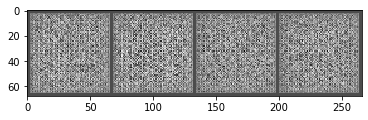

Epoch: 0, Discriminator Loss: 4.1187, Generator Loss: 52.8052, AvgDiscriminator Loss: 4.1435, AvgGenerator Loss: 52.1167:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

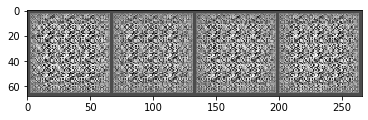

  0%|          | 0/191 [00:00<?, ?it/s]

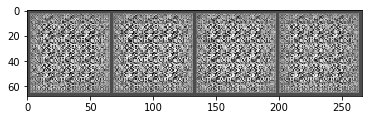

Epoch: 1, Discriminator Loss: 5.2726, Generator Loss: 1.2084, AvgDiscriminator Loss: 4.0784, AvgGenerator Loss: 49.4140:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

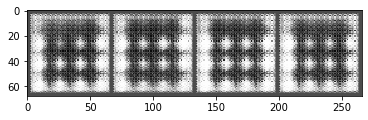

  0%|          | 0/191 [00:00<?, ?it/s]

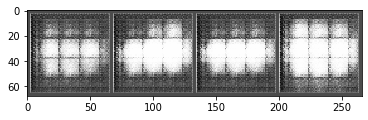

Epoch: 2, Discriminator Loss: 0.8808, Generator Loss: 2.2914, AvgDiscriminator Loss: 3.3580, AvgGenerator Loss: 31.4405:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

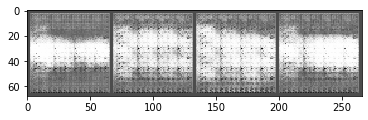

  0%|          | 0/191 [00:00<?, ?it/s]

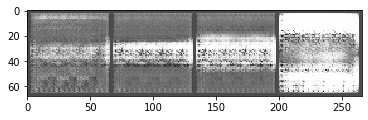

Epoch: 3, Discriminator Loss: 0.6620, Generator Loss: 1.9407, AvgDiscriminator Loss: 2.6134, AvgGenerator Loss: 22.9213:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

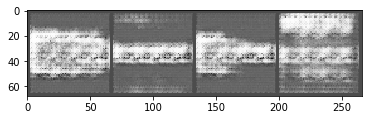

  0%|          | 0/191 [00:00<?, ?it/s]

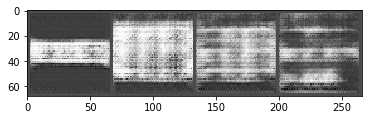

Epoch: 4, Discriminator Loss: 0.6290, Generator Loss: 1.7877, AvgDiscriminator Loss: 2.1844, AvgGenerator Loss: 18.1714:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

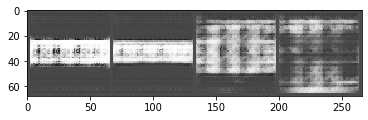

  0%|          | 0/191 [00:00<?, ?it/s]

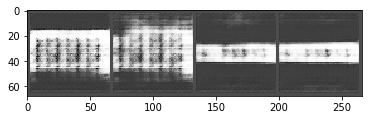

Epoch: 5, Discriminator Loss: 0.7222, Generator Loss: 0.5701, AvgDiscriminator Loss: 1.8996, AvgGenerator Loss: 15.1611:  52%|█████▏    | 100/191 [02:57<02:52,  1.90s/it]

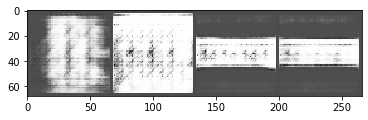

  0%|          | 0/191 [00:00<?, ?it/s]

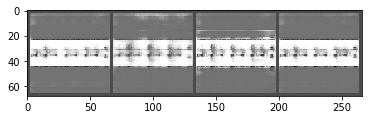

Epoch: 6, Discriminator Loss: 0.5649, Generator Loss: 0.8263, AvgDiscriminator Loss: 1.7016, AvgGenerator Loss: 13.0710:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

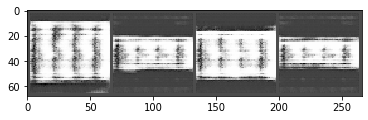

  0%|          | 0/191 [00:00<?, ?it/s]

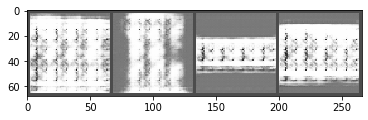

Epoch: 7, Discriminator Loss: 0.5040, Generator Loss: 0.8824, AvgDiscriminator Loss: 1.5611, AvgGenerator Loss: 11.5353:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

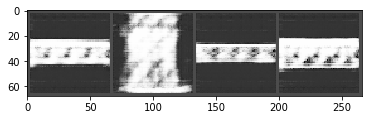

  0%|          | 0/191 [00:00<?, ?it/s]

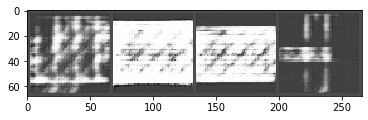

Epoch: 8, Discriminator Loss: 0.8210, Generator Loss: 0.4578, AvgDiscriminator Loss: 1.4482, AvgGenerator Loss: 10.3693:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

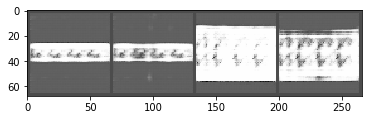

  0%|          | 0/191 [00:00<?, ?it/s]

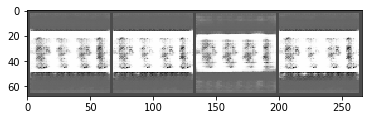

Epoch: 9, Discriminator Loss: 0.8641, Generator Loss: 0.5036, AvgDiscriminator Loss: 1.3577, AvgGenerator Loss: 9.4481:  52%|█████▏    | 100/191 [02:57<02:51,  1.88s/it]

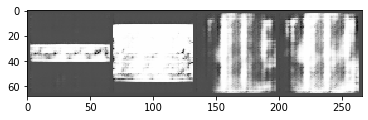

  0%|          | 0/191 [00:00<?, ?it/s]

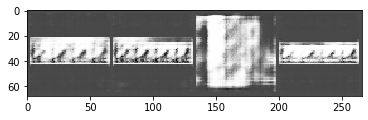

Epoch: 10, Discriminator Loss: 0.5313, Generator Loss: 0.7894, AvgDiscriminator Loss: 1.2815, AvgGenerator Loss: 8.7103:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

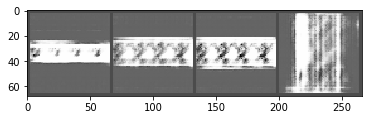

  0%|          | 0/191 [00:00<?, ?it/s]

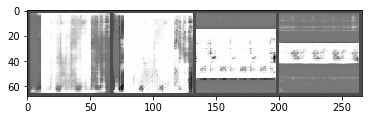

Epoch: 11, Discriminator Loss: 0.4303, Generator Loss: 1.3558, AvgDiscriminator Loss: 1.2213, AvgGenerator Loss: 8.0924:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

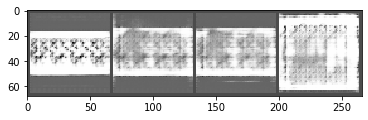

  0%|          | 0/191 [00:00<?, ?it/s]

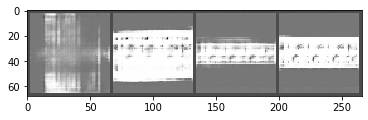

Epoch: 12, Discriminator Loss: 0.7439, Generator Loss: 0.5327, AvgDiscriminator Loss: 1.1678, AvgGenerator Loss: 7.5876:  52%|█████▏    | 100/191 [02:57<02:51,  1.88s/it]

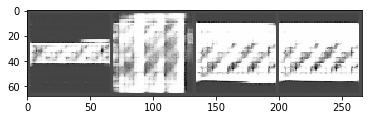

  0%|          | 0/191 [00:00<?, ?it/s]

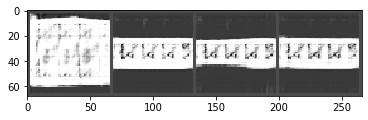

Epoch: 13, Discriminator Loss: 0.3976, Generator Loss: 2.2185, AvgDiscriminator Loss: 1.1218, AvgGenerator Loss: 7.1503:  52%|█████▏    | 100/191 [02:57<02:51,  1.88s/it]

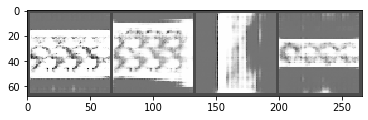

  0%|          | 0/191 [00:00<?, ?it/s]

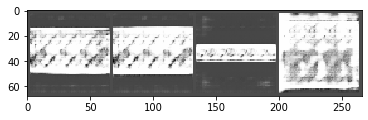

Epoch: 14, Discriminator Loss: 0.4164, Generator Loss: 1.3280, AvgDiscriminator Loss: 1.0837, AvgGenerator Loss: 6.7781:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

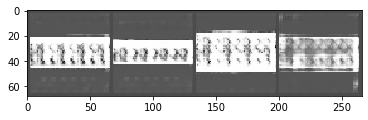

  0%|          | 0/191 [00:00<?, ?it/s]

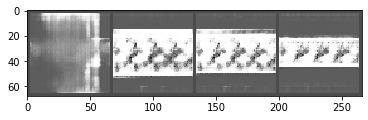

Epoch: 15, Discriminator Loss: 0.4832, Generator Loss: 1.6288, AvgDiscriminator Loss: 1.0496, AvgGenerator Loss: 6.4501:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

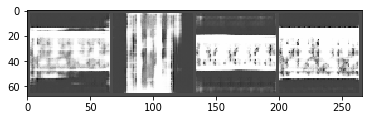

  0%|          | 0/191 [00:00<?, ?it/s]

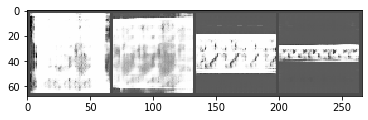

Epoch: 16, Discriminator Loss: 0.5455, Generator Loss: 0.7578, AvgDiscriminator Loss: 1.0187, AvgGenerator Loss: 6.1603:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

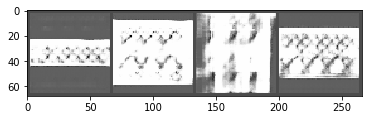

  0%|          | 0/191 [00:00<?, ?it/s]

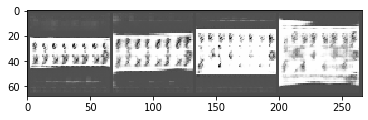

Epoch: 17, Discriminator Loss: 0.3852, Generator Loss: 1.4096, AvgDiscriminator Loss: 0.9937, AvgGenerator Loss: 5.9024:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

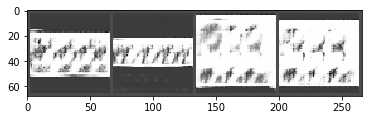

  0%|          | 0/191 [00:00<?, ?it/s]

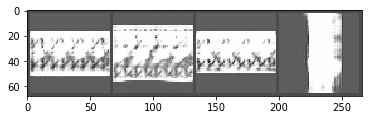

Epoch: 18, Discriminator Loss: 0.4090, Generator Loss: 1.5352, AvgDiscriminator Loss: 0.9670, AvgGenerator Loss: 5.6809:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

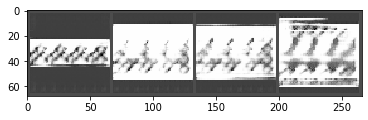

  0%|          | 0/191 [00:00<?, ?it/s]

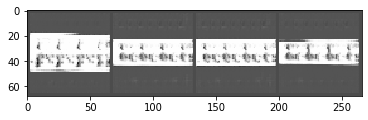

Epoch: 19, Discriminator Loss: 0.6371, Generator Loss: 0.9168, AvgDiscriminator Loss: 0.9436, AvgGenerator Loss: 5.4876:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

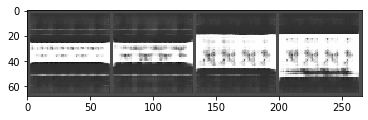

  0%|          | 0/191 [00:00<?, ?it/s]

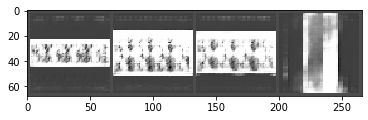

Epoch: 20, Discriminator Loss: 0.4918, Generator Loss: 1.2401, AvgDiscriminator Loss: 0.9260, AvgGenerator Loss: 5.2973:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

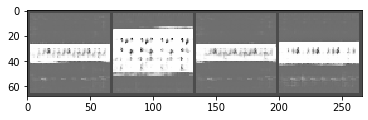

  0%|          | 0/191 [00:00<?, ?it/s]

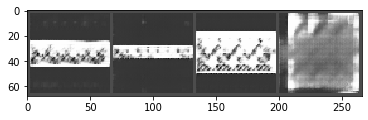

Epoch: 21, Discriminator Loss: 0.5201, Generator Loss: 1.2091, AvgDiscriminator Loss: 0.9059, AvgGenerator Loss: 5.1326:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

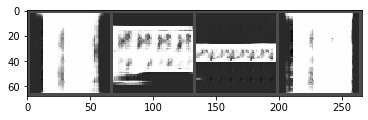

  0%|          | 0/191 [00:00<?, ?it/s]

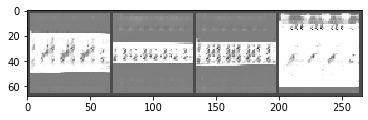

Epoch: 22, Discriminator Loss: 0.4108, Generator Loss: 1.3399, AvgDiscriminator Loss: 0.8878, AvgGenerator Loss: 4.9830:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

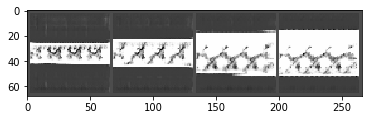

  0%|          | 0/191 [00:00<?, ?it/s]

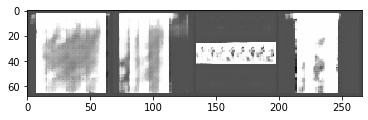

Epoch: 23, Discriminator Loss: 0.3749, Generator Loss: 2.0516, AvgDiscriminator Loss: 0.8700, AvgGenerator Loss: 4.8504:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

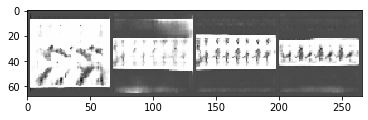

  0%|          | 0/191 [00:00<?, ?it/s]

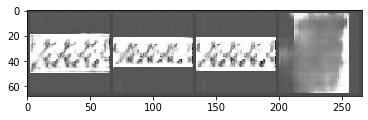

Epoch: 24, Discriminator Loss: 0.3992, Generator Loss: 2.2059, AvgDiscriminator Loss: 0.8524, AvgGenerator Loss: 4.7318:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

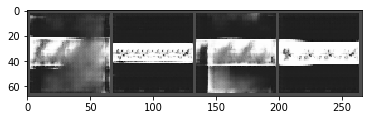

  0%|          | 0/191 [00:00<?, ?it/s]

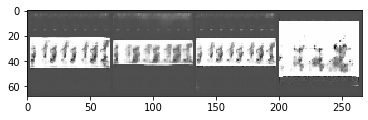

Epoch: 25, Discriminator Loss: 0.4152, Generator Loss: 1.2206, AvgDiscriminator Loss: 0.8390, AvgGenerator Loss: 4.6157:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

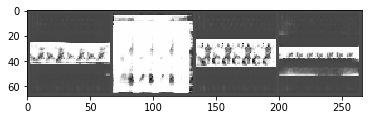

  0%|          | 0/191 [00:00<?, ?it/s]

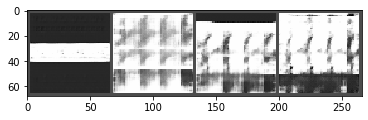

Epoch: 26, Discriminator Loss: 0.3616, Generator Loss: 1.9532, AvgDiscriminator Loss: 0.8247, AvgGenerator Loss: 4.5153:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

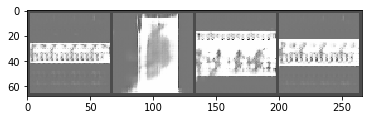

  0%|          | 0/191 [00:00<?, ?it/s]

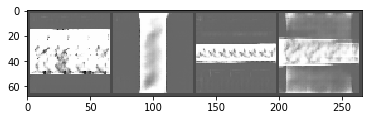

Epoch: 27, Discriminator Loss: 0.3461, Generator Loss: 1.7230, AvgDiscriminator Loss: 0.8080, AvgGenerator Loss: 4.4271:  52%|█████▏    | 100/191 [02:57<02:52,  1.90s/it]

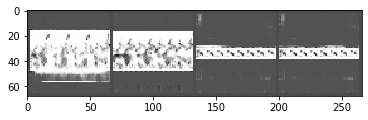

  0%|          | 0/191 [00:00<?, ?it/s]

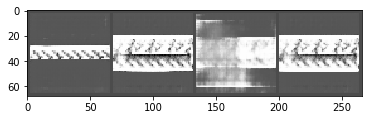

Epoch: 28, Discriminator Loss: 0.9730, Generator Loss: 1.2434, AvgDiscriminator Loss: 0.7971, AvgGenerator Loss: 4.3478:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

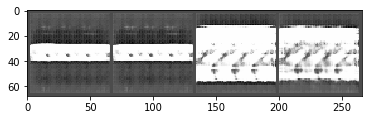

  0%|          | 0/191 [00:00<?, ?it/s]

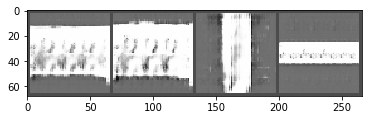

Epoch: 29, Discriminator Loss: 0.5198, Generator Loss: 1.0049, AvgDiscriminator Loss: 0.7958, AvgGenerator Loss: 4.2434:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

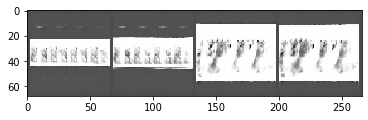

  0%|          | 0/191 [00:00<?, ?it/s]

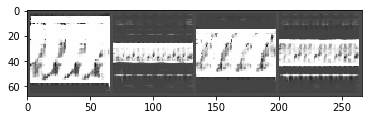

Epoch: 30, Discriminator Loss: 0.6469, Generator Loss: 2.4217, AvgDiscriminator Loss: 0.7898, AvgGenerator Loss: 4.1498:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

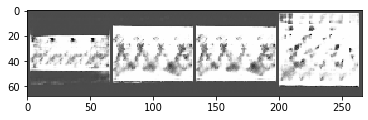

  0%|          | 0/191 [00:00<?, ?it/s]

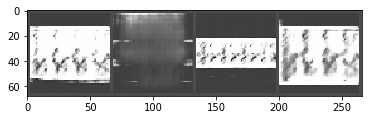

Epoch: 31, Discriminator Loss: 0.3826, Generator Loss: 1.5368, AvgDiscriminator Loss: 0.7820, AvgGenerator Loss: 4.0680:  52%|█████▏    | 100/191 [02:57<02:52,  1.90s/it]

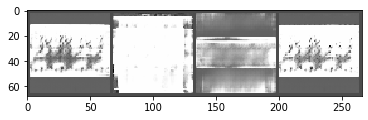

  0%|          | 0/191 [00:00<?, ?it/s]

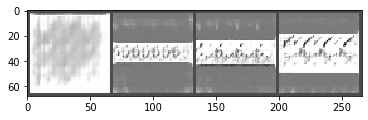

Epoch: 32, Discriminator Loss: 0.3447, Generator Loss: 2.0687, AvgDiscriminator Loss: 0.7707, AvgGenerator Loss: 4.0013:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

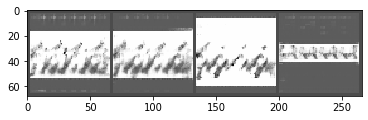

  0%|          | 0/191 [00:00<?, ?it/s]

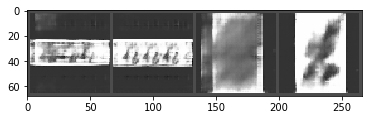

Epoch: 33, Discriminator Loss: 0.4289, Generator Loss: 1.8821, AvgDiscriminator Loss: 0.7599, AvgGenerator Loss: 3.9426:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

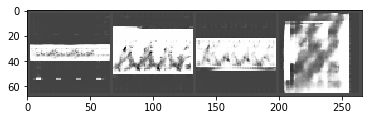

  0%|          | 0/191 [00:00<?, ?it/s]

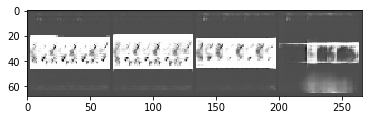

Epoch: 34, Discriminator Loss: 0.4231, Generator Loss: 1.1679, AvgDiscriminator Loss: 0.7507, AvgGenerator Loss: 3.8886:  52%|█████▏    | 100/191 [02:57<02:51,  1.89s/it]

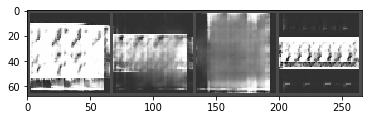

  0%|          | 0/191 [00:00<?, ?it/s]

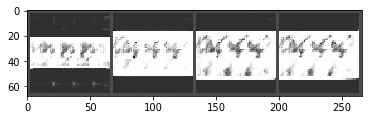

Epoch: 35, Discriminator Loss: 0.4466, Generator Loss: 1.3185, AvgDiscriminator Loss: 0.7415, AvgGenerator Loss: 3.8346:  52%|█████▏    | 100/191 [02:57<02:52,  1.90s/it]

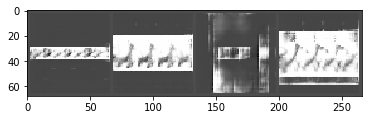

  0%|          | 0/191 [00:00<?, ?it/s]

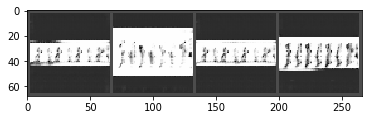

Epoch: 36, Discriminator Loss: 0.4008, Generator Loss: 1.3628, AvgDiscriminator Loss: 0.7344, AvgGenerator Loss: 3.7836:  52%|█████▏    | 100/191 [02:57<02:52,  1.89s/it]

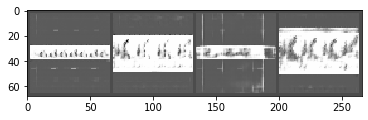

  0%|          | 0/191 [00:00<?, ?it/s]

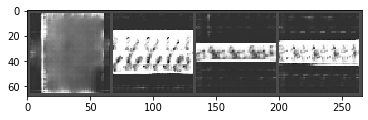

Epoch: 37, Discriminator Loss: 0.3602, Generator Loss: 1.7486, AvgDiscriminator Loss: 0.7295, AvgGenerator Loss: 3.7559:   8%|▊         | 15/191 [00:28<04:46,  1.63s/it]

---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py in __call__(self=BCELoss(), *input=(tensor([0.3140, 0.1800, 0.0684, 0.2359, 0.1787, ...vice='cuda:0',
       grad_fn=<SqueezeBackward0>), tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, ...0.1000, 0.1000, 0.1000, 0.1000], device='cuda:0')), **kwargs={})
    530             result = self._slow_forward(*input, **kwargs)
    531         else:
--> 532             result = self.forward(*input, **kwargs)
        result = undefined
        self.forward = <bound method BCELoss.forward of BCELoss()>
        input = (tensor([0.3140, 0.1800, 0.0684, 0.2359, 0.1787, 0.1321, 0.1630, 0.0357, 0.1141,
        0.2448, 0.1897, 0.2818, 0.0664, 0.0352, 0.2020, 0.0262, 0.0667, 0.2086,
        0.2308, 0.2160, 0.1873, 0.1444, 0.2681, 0.0985, 0.1416, 0.2110, 0.0888,
        0.0584, 0.1729, 0.177

In [0]:
generator, d_losses, g_losses = train()